In [1]:
library(glmnet)

# Feature selection and regularised regression


#Goal: give us an impression of what these methods can be used for, but
# also what limitations they have.


#WARNING: Both parts of assignment require some amount of repeated simulation/
# estimation of models which can take some time to run!

## ---- PART 1: Prediction quality vs feature selection ------------------------

# Lasso encodes variable selection through penalisation. 
#install.packages("tidyverse")
#install.packages("glmnet", repos = "https://cran.us.r-project.org")
library(tidyverse)
library(latex2exp)

# Simulating data: 

#' 
#' @param n Number of samples 
#' @param p Number of features
#' @param sparsity Percentage of zero elements in simulated regression coefficients
#' @param SNR Signal-to-noise ratio (see explanation above)
#' @param scaling.beta Scaling for the coefficient to make sure they are large
#' 
#' @return A list containing
#     {X}{n x p matrix of features}
#     {y}{n vector of responses}
#     {beta}{p vector of regression coefficients}

## ---- Simulating data --------------------------------------------------------



sim.data.corr <- function(n, p, sparsity, SNR, scaling.beta = 5){
  
  # Standardisation function
  stand. <- function(x) {
    x <- (x - mean(x)) / sd(x)
  }
  
  
  
  #ps <- sum(p)
  
  
  # Decide how correlated variables
  corr.1 <- 0.8
  #corr.2 <- 0.2
  #corr.3 <- 0.3
  
  # NOTE: this is how much noise one addds to the identical feature copies in the 
  # groups -> smaller value of corr.X = higher correlation between variables 
  # (a.k.a less noise added)
  
  # Create correlated variables 
  
  X<-rnorm(n)
  X<-matrix(rep(X,p[1]),n,p[1],byrow=F)+matrix(rnorm(n*p[1],sd=corr.1),n,p[1])
  X<-apply(X,2,stand.)
  
  
  # #
  # x2<-rnorm(n)
  # x2<-matrix(rep(x2,p[2]),n,p[2],byrow=F)+matrix(rnorm(n*p[2],sd=corr.2),n,p[2])
  # x2<-apply(x2,2,stand.)
  # #
  # x3<-rnorm(n)
  # x3<-matrix(rep(x3,p[3]),n,p[3],byrow=F)+matrix(rnorm(n*p[3],sd=corr.3),n,p[3])
  # x3<-apply(x3,2,stand.)
  # 
  # 
  # #  a fourth group with no correlation
  # x4<-matrix(rnorm(n*p[4]),n,p[4])
  # x4<-apply(x4,2,stand.)
  # 
  # 
  #X <- matrix(rnorm(n*p), ncol = p) # nXp design matrix 
  
  
  
  
  
  non.zero.coeff <- ceiling((1-sparsity)*p) # Number of non-zero coeff
  
  # ceiling will take a numeric number (such as 1.1) and return the integer
  # closest and higher in value to this number (so 2 in my example)
  
  beta <- rep.int(0,p) #initialise 1Xp vector with 0
  
  beta[1:non.zero.coeff] <- scaling.beta * rnorm(non.zero.coeff) # Insert q scaled coeff from sd normal dist
  
  # (sd is beta_scale for the betas)
  
  
  # I think what we are doing here is basically creating some noise/
  # a sample
  # beta*X is the noise-less response
  # beta*X + sigma*epsilon is the actual response
  # sigma = sd_noise = sd_signal/SNR - we generate a reasonable noise sd
  
  # (So basically like we did with beta_scale above, we want to rescale
  # our random error so that we get reasonable results)
  sd.noise <- sqrt(sum((X %*% beta)^2)/(n-1))/SNR 
  
  
  y <- X%*%beta + sd.noise * rnorm(n) # Response 
  
  # We do not want the non-zero features in the first (1-sparsity)p 
  # number of columns only, so we reorder the columns:
  
  reord <- sample(p, p, replace = F)
  
  
  #X <- cbind(x1,x2,x3,x4)
  
  
  
  list(
    
    X = X[, reord],
    y = y,
    beta = beta[reord]
  )
  
}

## ---- Correlated data via demo 10 --------------------------------------------





Warning message:
"package 'glmnet' was built under R version 4.1.3"
Loading required package: Matrix

Loaded glmnet 4.1-4

Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts -----------------------

In [12]:
library(MASS)

SS <- c(2,3,4) 
n.train <- c(200,500,750)
sparse <- c(0.75,0.925,0.99)


M <- 50

p <- 1000

## ---- SPARSITY ---------------------------------------------------------------


n <- n.train[2] 
SND <- SS[1]
sparsity <- sparse[2]







min.beta <- matrix(0, 1,p)
se.beta <- matrix(0, 1,p)
true.beta <- matrix(0, 1,p)




# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.

#for (l in (1:length(sparse))){
#  sparsity <- sparse[l]
  
  # coef.min <- matrix(0, 1,p)
  # coef.1se <- matrix(0, 1,p)
  # coef.true <- matrix(0, 1,p)
  # 
  # 
  beta.min <- matrix(0, 1, p)
  beta.1se <- matrix(0, 1, p)
  beta.true <- matrix(0, 1,p)
  
 # for (j in (1:length(n.train))){

    
    
    return <- sim.data.corr(n,p,sparsity,SND)
    
    suppressMessages(attach(return))
    
    
    beta.true.1 <- return$beta
   
    
    
    # Loop to create M bootstrap models
    for ( i in 1:M) {
      
      # The bootstrapped data (replace = T is important!)
      #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
      
      # Row id for bootstrapping
      id <- sample(n, size = n, replace = T)
      
      # Bootstrapped data and labels
      boot.X <- X[id,]
      boot.y <- y[id,]
      
      # Create model for bootstrapped data
      lasso.cv <- cv.glmnet(
        x = boot.X, y = boot.y,
        keep = T,
        alpha = 1,
        type.measure = "mse")
      
      
      #pred.min <- predict(lasso.cv, newx = boot.X, s = "lambda.min")
      pred.1se <- predict(lasso.cv, newx = boot.X, s = "lambda.1se")
      
      #beta.min.1 <- coef(lasso.cv, s = "lambda.min")[-1]
      beta.1se.1 <- coef(lasso.cv, s = "lambda.1se")[-1]
      
      
      
       for ( ll in (1:p)){
      #   
      #   if( beta.min.1[ll] > 0){
      #     
      #     beta.min[ll] <- beta.min[ll] + 1
      #     
      #   }
        if( beta.1se.1[ll] > 0){
          
          beta.1se[ll] <- beta.1se[ll] + 1
          
        }
        if( beta.true.1[ll] > 0){
          
          beta.true[ll] <- beta.true[ll] + 1
          
        }
        
      }
      
    }

  #min.beta[l,] <- beta.min
  se.beta <- beta.1se
  true.beta <- beta.true
  
  


#min.beta <- as.data.frame(min.beta)
se.beta <- as.data.frame(se.beta)
true.beta <- as.data.frame(true.beta)

# ---- standard deviation ------------------------------------------------------

# sd.selected.min <- as.data.frame(matrix(NA, 
#                                         nrow = dim(min.beta)[1],
#                                         ncol = dim(min.beta)[2],
#                                         dimnames = list(rownames(min.beta),
#                                                         colnames(min.beta))))
sd.selected.1se <- as.data.frame(matrix(NA, 
                                        nrow = dim(min.beta)[1],
                                        ncol = dim(min.beta)[2],
                                        dimnames = list(rownames(se.beta),
                                                        colnames(se.beta))))

sd.selected.true <- as.data.frame(matrix(NA, 
                                         nrow = dim(se.beta)[1],
                                         ncol = dim(se.beta)[2],
                                         dimnames = list(rownames(se.beta),
                                                         colnames(se.beta))))


for ( i in (1:length(sd.selected.1se[,1]))){
  for (j in (1:length(sd.selected.1se[1,]))){
    
    #sd.selected.min[i,j] <- sd(c(rep(0, ((M**length(sparse))-min.beta[i,j])), rep(1, min.beta[i,j])))
    
    sd.selected.1se[i,j] <- sd(c(rep(0, (M-se.beta[i,j])), rep(1, se.beta[i,j])))
    
    #sd.selected.true[i,j] <- sd(c(rep(0, (M-true.beta[i,j])), rep(1, true.beta[i,j])))
    
    
  }
}



V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,freq,sd
,<dbl>,<dbl>
V93,50,0
V95,50,0
V96,50,0
V124,50,0
V137,50,0
V205,50,0
V214,50,0
V220,50,0
V244,50,0


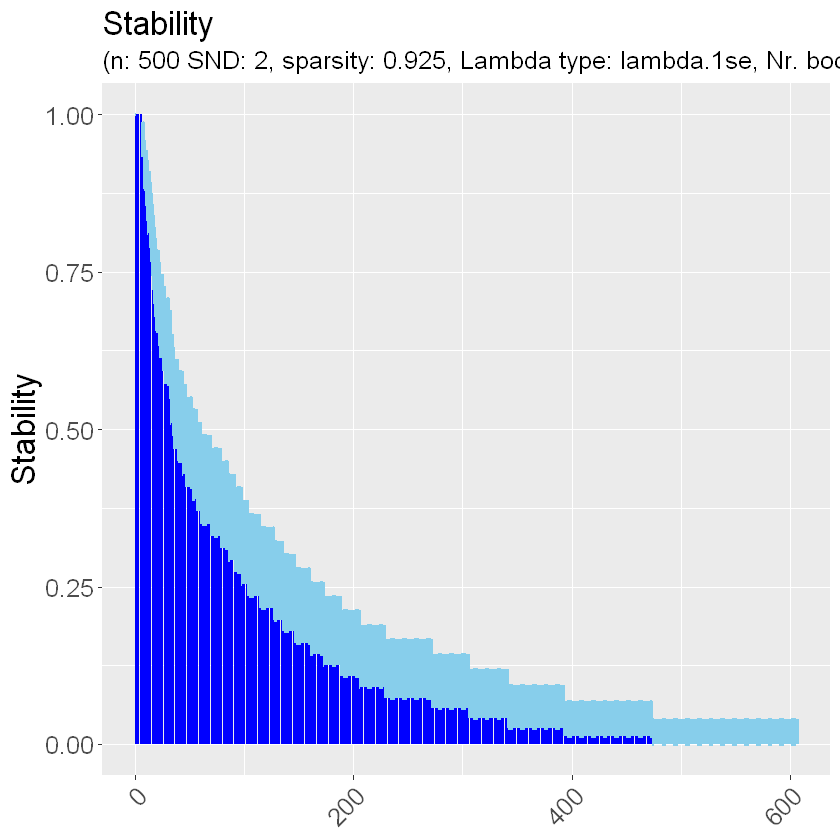

In [19]:


## ---- lambda.1se -------------------------------------------------------------

se.tot <- as.data.frame(cbind((t(se.beta[1,])),t((sd.selected.1se[1,]))))
colnames(se.tot) <- c("freq","sd")

nz.se.tot <- subset(se.tot, se.tot$freq>0)
nz.se.tot <- nz.se.tot[order(nz.se.tot$freq, decreasing = T),]

true.beta



true.tot <- as.data.frame(cbind(t(true.beta), rep(0, p)))
colnames(true.tot) <- c("freq","sd")
#row.names(true.tot) <- colnames(true.beta)
nz.true.tot <- subset(true.tot, true.tot$freq>0)
nz.true.tot <- nz.true.tot[order(nz.true.tot$freq, decreasing = T),]

nz.true.tot
## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability",
       subtitle = paste0("(n: ",n," SND: ",SND,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


,freq,sd
,<dbl>,<dbl>
V95,50,0.0000000
V124,50,0.0000000
V205,50,0.0000000
V880,50,0.0000000
V903,50,0.0000000
V974,50,0.0000000
V270,48,0.1979487
V767,48,0.1979487
V941,46,0.2740475


,freq,sd
,<dbl>,<dbl>
V93,50,0
V95,50,0
V96,50,0
V124,50,0
V137,50,0
V205,50,0
V214,50,0
V220,50,0
V244,50,0


Warning message in row.names(nz.se.tot.thresh) == row.names(nz.true.tot):
"longer object length is not a multiple of shorter object length"


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE FALSE FALSE

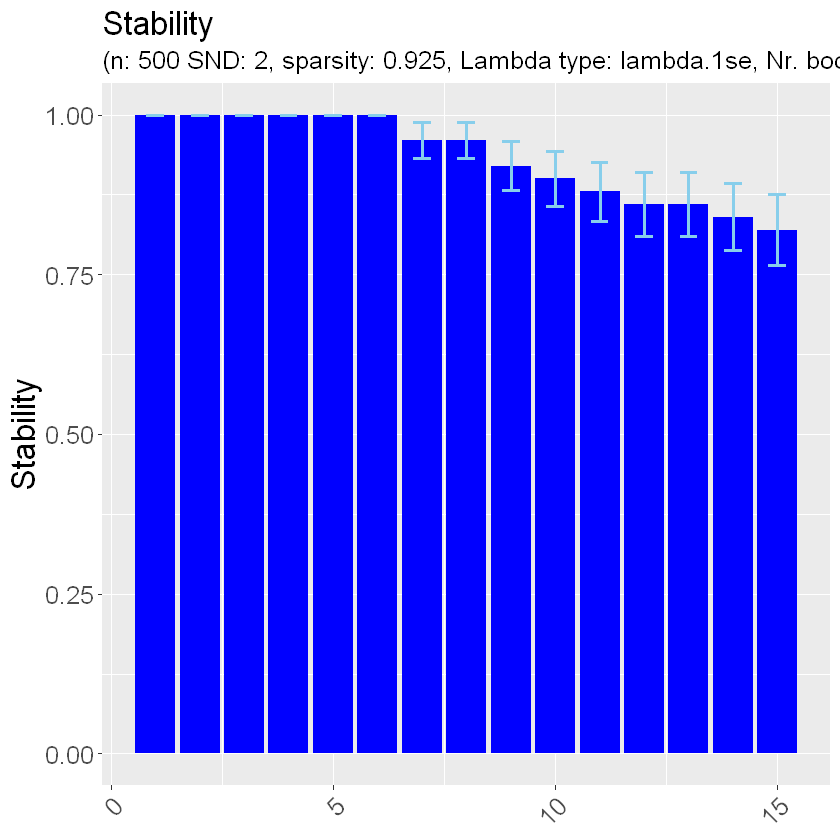

In [26]:


## ---- lambda.1se -------------------------------------------------------------

nz.se.tot.thresh <- subset(nz.se.tot, nz.se.tot$freq > ceiling(M*0.8))
#nz.true.tot.thresh <- nz.true.tot[nz.se.tot$freq > ceiling(M*0.8)]
## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability",
       subtitle = paste0("(n: ",n," SND: ",SND,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

#A <- cbind(nz.true.tot.thresh, nz.se.tot.thresh)

list(nz.se.tot.thresh)
list(nz.true.tot)
row.names(nz.se.tot.thresh) == row.names(nz.true.tot)

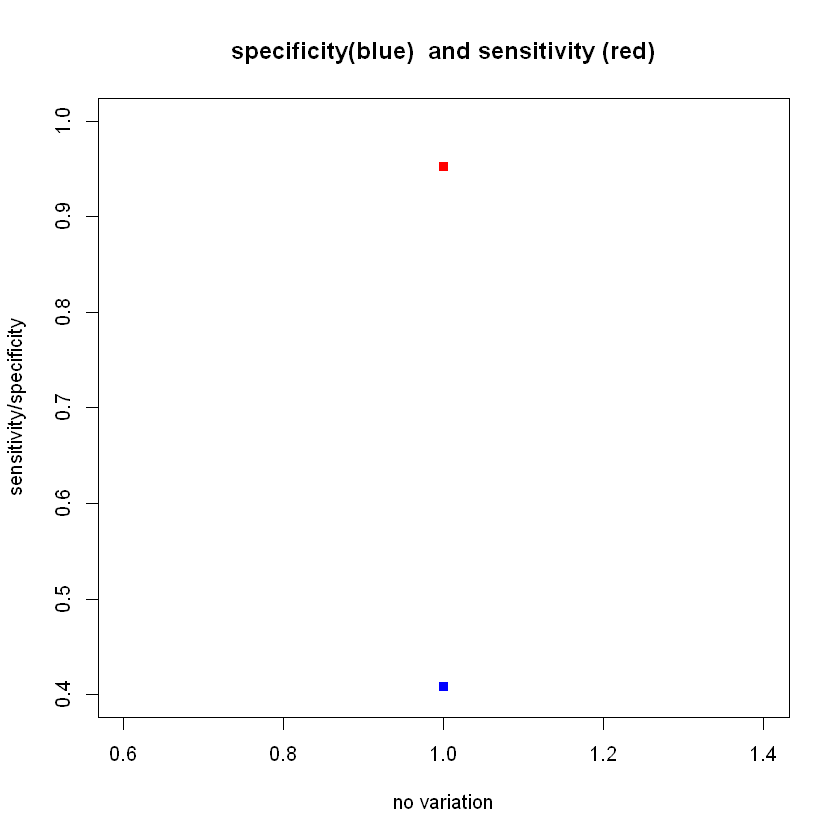

In [27]:
## ---- Comparing true and sparsity --------------------------------------------



specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- u > 0
  
  # Remove all zero entries in v
  u <- u[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  v <- v[non.zero.entries.est]
  
  # non-zero entries in u
  zero.in.true <- v == 0
  
  # Remove all zero entries in what is left of u
  v <- v[zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/(length(u)+length(v))
  
  return <- sens
  
}




spec.1se <- matrix(0, dim(se.beta)[1],1)
sens.1se <- matrix(0, dim(se.beta)[1],1)


for (i in (1:dim(se.beta)[1])){
  
  
  
  spec.1se[i] <- specificity(se.beta[i, ], true.beta[i, ])
  sens.1se[i] <- sensitivity(se.beta[i, ], true.beta[i, ])
  
  
}

dd <- as.data.frame(cbind(spec.1se,sens.1se, c(1)))

colnames(dd) <- c("spec.1se","sens.1se", "variable")

variable <- as.factor(dd$variable)




# create base scatter plot
plot(dd$variable, dd$spec.1se,
     ylim = c(0.4,1), col='blue', pch=18, type = "l",
     main = "specificity(blue)  and sensitivity (red)",
     xlab = "no variation", ylab = "sensitivity/specificity")

# overlay scatter plot 
points(dd$variable, dd$sens.1se, col='red', pch=15, type = "l")
points(dd$variable, dd$sens.1se, col='red', pch=15)
points(dd$variable, dd$spec.1se, col='blue', pch=15)


In [33]:
 A <- as.data.frame(cbind(row.names(nz.true.tot[c(1:5),]),row.names(nz.se.tot[c(1:5),])))

colnames(A) <- c("true", "lasso")
 
A


true,lasso
<chr>,<chr>
V93,V95
V95,V124
V96,V205
V124,V880
V137,V903


In [2]:
library(MASS)

SS <- c(2,3,4) 
n.train <- c(200,500,750)
sparse <- c(0.75,0.925,0.99)


M <- 50

p <- 1000

## ---- SPARSITY ---------------------------------------------------------------


n <- n.train[2] 
SND <- SS[2]








min.beta <- matrix(0, length(sparse),p)
se.beta <- matrix(0, length(sparse),p)
true.beta <- matrix(0, length(sparse),p)




# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.

for (l in (1:length(sparse))){
  sparsity <- sparse[l]
  
  # coef.min <- matrix(0, 1,p)
  # coef.1se <- matrix(0, 1,p)
  # coef.true <- matrix(0, 1,p)
  # 
  # 
  beta.min <- matrix(0, 1, p)
  beta.1se <- matrix(0, 1, p)
  beta.true <- matrix(0, 1,p)
  
 # for (j in (1:length(n.train))){

    
    
    return <- sim.data.corr(n,p,sparsity,SND)
    
    suppressMessages(attach(return))
    
       beta.true.1 <- return$beta
  
    
    
    
    # Loop to create M bootstrap models
    for ( i in 1:M) {
      
      # The bootstrapped data (replace = T is important!)
      #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
      
      # Row id for bootstrapping
      id <- sample(n, size = n, replace = T)
      
      # Bootstrapped data and labels
      boot.X <- X[id,]
      boot.y <- y[id,]
      
      # Create model for bootstrapped data
      lasso.cv <- cv.glmnet(
        x = boot.X, y = boot.y,
        keep = T,
        alpha = 1,
        type.measure = "mse")
      
      
      #pred.min <- predict(lasso.cv, newx = boot.X, s = "lambda.min")
      pred.1se <- predict(lasso.cv, newx = boot.X, s = "lambda.1se")
      
      #beta.min.1 <- coef(lasso.cv, s = "lambda.min")[-1]
      beta.1se.1 <- coef(lasso.cv, s = "lambda.1se")[-1]
      #beta.true.1 <- return$beta
      
      
      
       for ( ll in (1:p)){
      #   
      #   if( beta.min.1[ll] > 0){
      #     
      #     beta.min[ll] <- beta.min[ll] + 1
      #     
      #   }
        if( beta.1se.1[ll] > 0){
          
          beta.1se[ll] <- beta.1se[ll] + 1
          
        }
      if( beta.true.1[ll] > 0){
          
          beta.true[ll] <- beta.true[ll] + 1
          
        }
        
      }
      
    }

  #min.beta[l,] <- beta.min
  se.beta[l,] <- beta.1se
  true.beta[l,] <- beta.true
  
  
}

#min.beta <- as.data.frame(min.beta)
se.beta <- as.data.frame(se.beta)
true.beta <- as.data.frame(true.beta)

# ---- standard deviation ------------------------------------------------------

# sd.selected.min <- as.data.frame(matrix(NA, 
#                                         nrow = dim(min.beta)[1],
#                                         ncol = dim(min.beta)[2],
#                                         dimnames = list(rownames(min.beta),
#                                                         colnames(min.beta))))
sd.selected.1se <- as.data.frame(matrix(NA, 
                                        nrow = dim(min.beta)[1],
                                        ncol = dim(min.beta)[2],
                                        dimnames = list(rownames(se.beta),
                                                        colnames(se.beta))))

sd.selected.true <- as.data.frame(matrix(NA, 
                                         nrow = dim(se.beta)[1],
                                         ncol = dim(se.beta)[2],
                                         dimnames = list(rownames(se.beta),
                                                         colnames(se.beta))))


for ( i in (1:length(sd.selected.1se[,1]))){
  for (j in (1:length(sd.selected.1se[1,]))){
    
    #sd.selected.min[i,j] <- sd(c(rep(0, ((M**length(sparse))-min.beta[i,j])), rep(1, min.beta[i,j])))
    
    sd.selected.1se[i,j] <- sd(c(rep(0, (M-se.beta[i,j])), rep(1, se.beta[i,j])))
    
    sd.selected.true[i,j] <- sd(c(rep(0, (M-true.beta[i,j])), rep(1, true.beta[i,j])))
    
    
  }
}



Warning message:
"package 'MASS' was built under R version 4.1.3"

Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




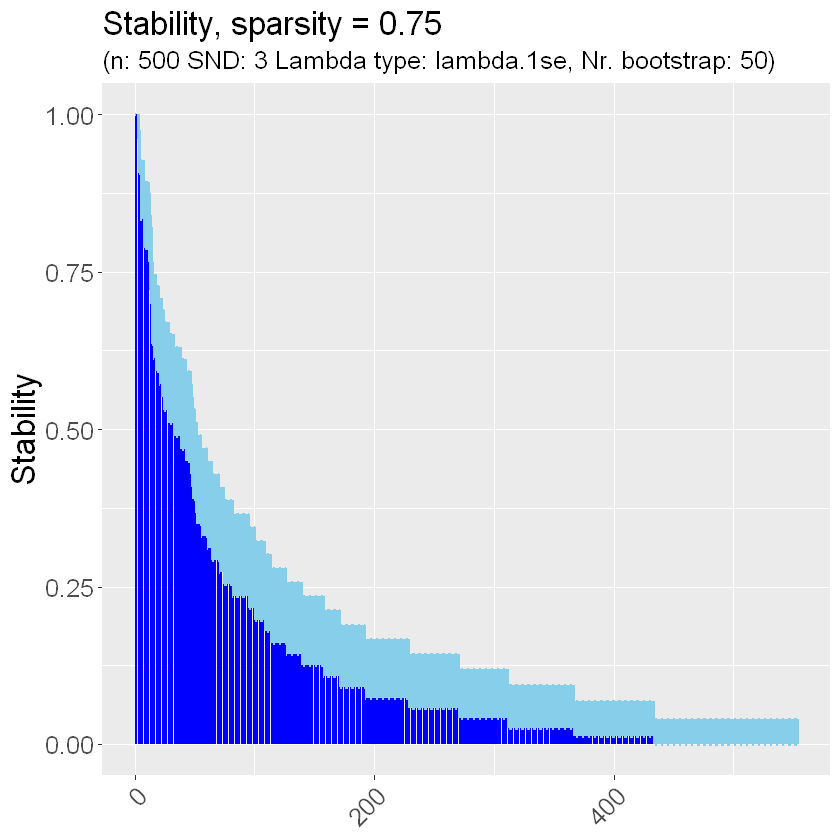

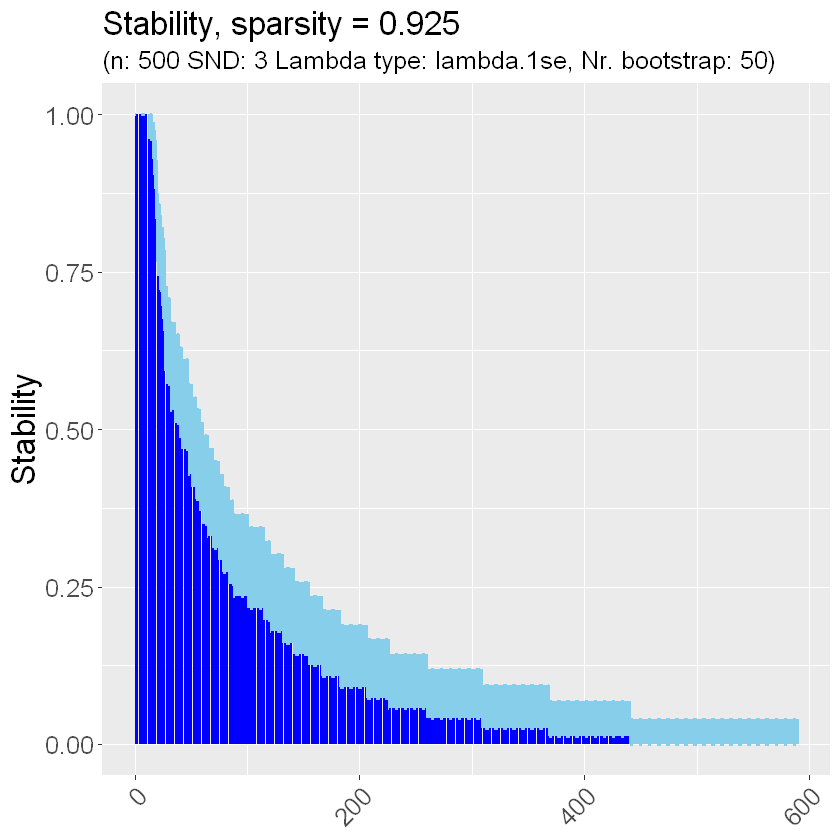

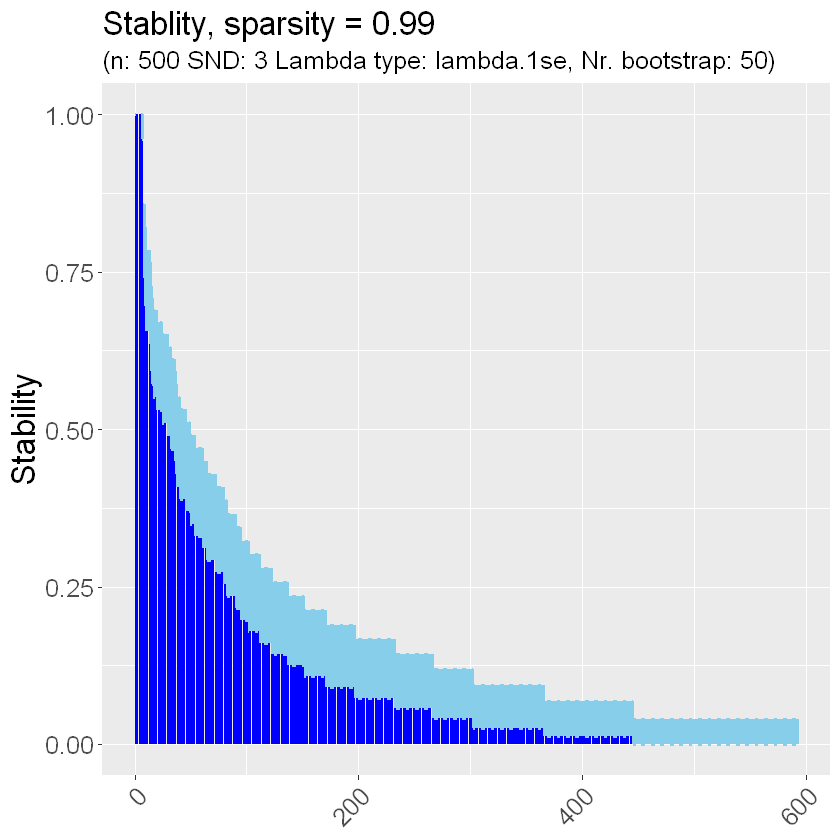

In [3]:


## ---- lambda.1se -------------------------------------------------------------

se.tot.0.75 <- as.data.frame(cbind((t(se.beta[1,])),t((sd.selected.1se[1,]))))
colnames(se.tot.0.75) <- c("freq","sd")

nz.se.tot.0.75 <- subset(se.tot.0.75, se.tot.0.75$freq>0)
nz.se.tot.0.75 <- nz.se.tot.0.75[order(nz.se.tot.0.75$freq, decreasing = T),]

se.tot.0.925 <- as.data.frame(cbind((t(se.beta[2,])),t((sd.selected.1se[2,]))))
colnames(se.tot.0.925) <- c("freq","sd")


nz.se.tot.0.925 <- subset(se.tot.0.925, se.tot.0.925$freq>0)
nz.se.tot.0.925 <- nz.se.tot.0.925[order(nz.se.tot.0.925$freq, decreasing = T),]


se.tot.0.99 <- as.data.frame(cbind((t(se.beta[3,])),t((sd.selected.1se[3,]))))
colnames(se.tot.0.99) <- c("freq","sd")

nz.se.tot.0.99 <- subset(se.tot.0.99, se.tot.0.99$freq>0)
nz.se.tot.0.99 <- nz.se.tot.0.99[order(nz.se.tot.0.99$freq, decreasing = T),]

## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.0.75)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.75)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.75)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.75",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.0.925)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.925)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.925)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.925",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.0.99)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.99)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.99)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stablity, sparsity = 0.99",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))






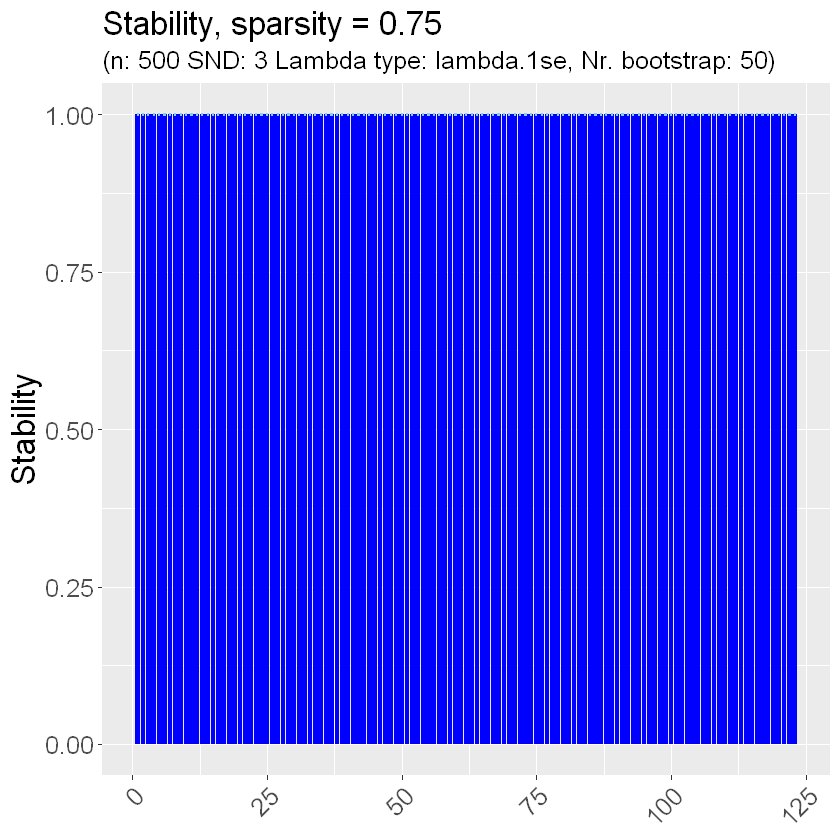

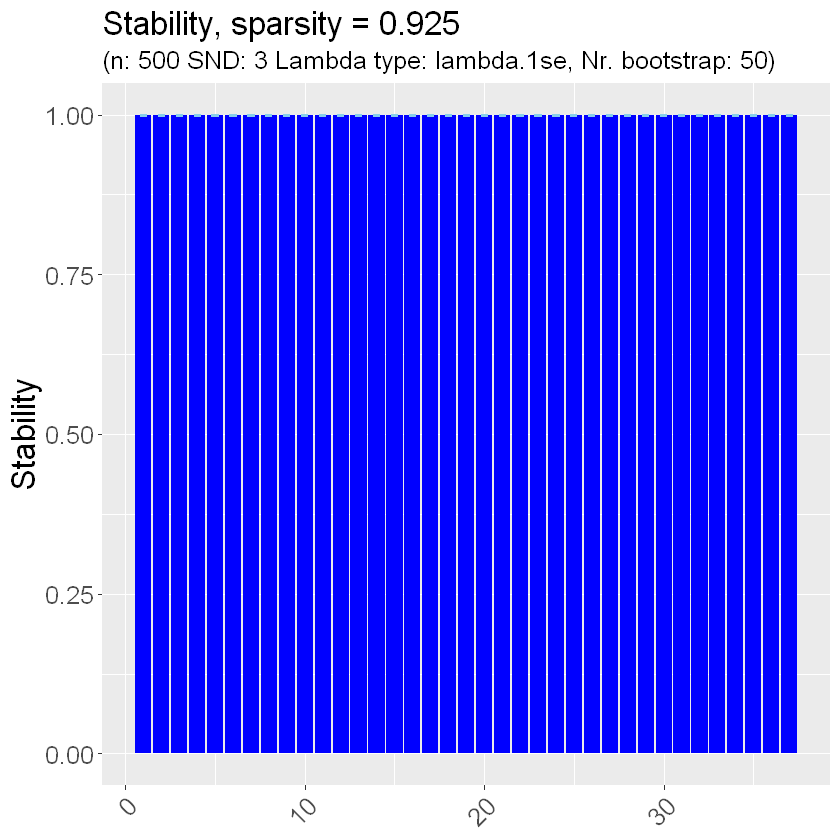

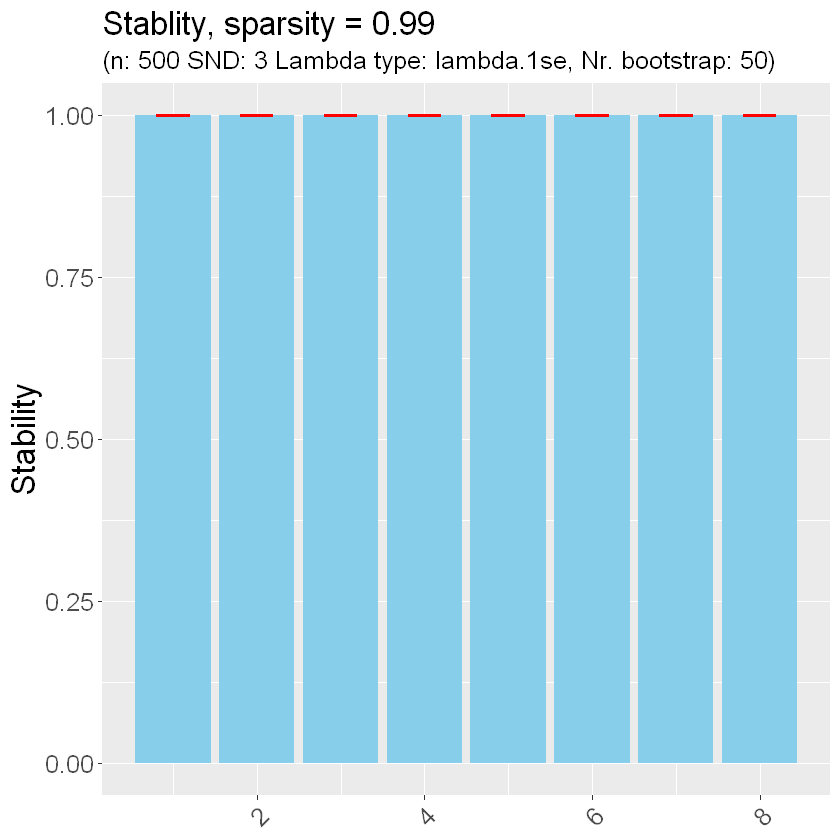

In [4]:

## ---- lambda.true ------------------------------------------------------------


true.tot.0.75 <- as.data.frame(cbind((t(true.beta[1,])),t((sd.selected.true[1,]))))
colnames(true.tot.0.75) <- c("freq","sd")

nz.true.tot.0.75 <- subset(true.tot.0.75, true.tot.0.75$freq>0)
nz.true.tot.0.75 <- nz.true.tot.0.75[order(nz.true.tot.0.75$freq, decreasing = T),]


true.tot.0.925 <- as.data.frame(cbind((t(true.beta[2,])),t((sd.selected.true[2,]))))
colnames(true.tot.0.925) <- c("freq","sd")

nz.true.tot.0.925 <- subset(true.tot.0.925, true.tot.0.925$freq>0)
nz.true.tot.0.925 <- nz.true.tot.0.925[order(nz.true.tot.0.925$freq, decreasing = T),]


true.tot.0.99 <- as.data.frame(cbind((t(true.beta[3,])),t((sd.selected.true[3,]))))
colnames(true.tot.0.99) <- c("freq","sd")

nz.true.tot.0.99 <- subset(true.tot.0.99, true.tot.0.99$freq>0)
nz.true.tot.0.99 <- nz.true.tot.0.99[order(nz.true.tot.0.99$freq, decreasing = T),]


## ---- plotting ---------------------------------------------------------------


ggplot((nz.true.tot.0.75)) +
  geom_bar(aes(x = c(1:dim(nz.true.tot.0.75)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.true.tot.0.75)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.75",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.true.tot.0.925)) +
  geom_bar(aes(x = c(1:dim(nz.true.tot.0.925)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.true.tot.0.925)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.925",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.true.tot.0.99)) +
  geom_bar(aes(x = c(1:dim(nz.true.tot.0.99)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "skyblue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.true.tot.0.99)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "red", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stablity, sparsity = 0.99",
       subtitle = paste0("(n: ",n," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


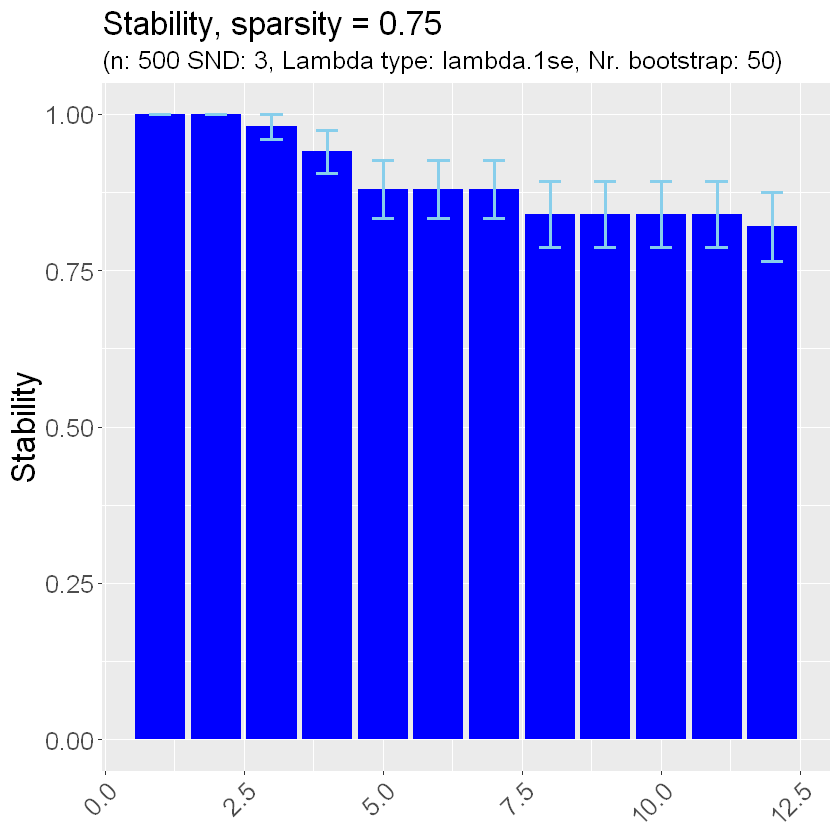

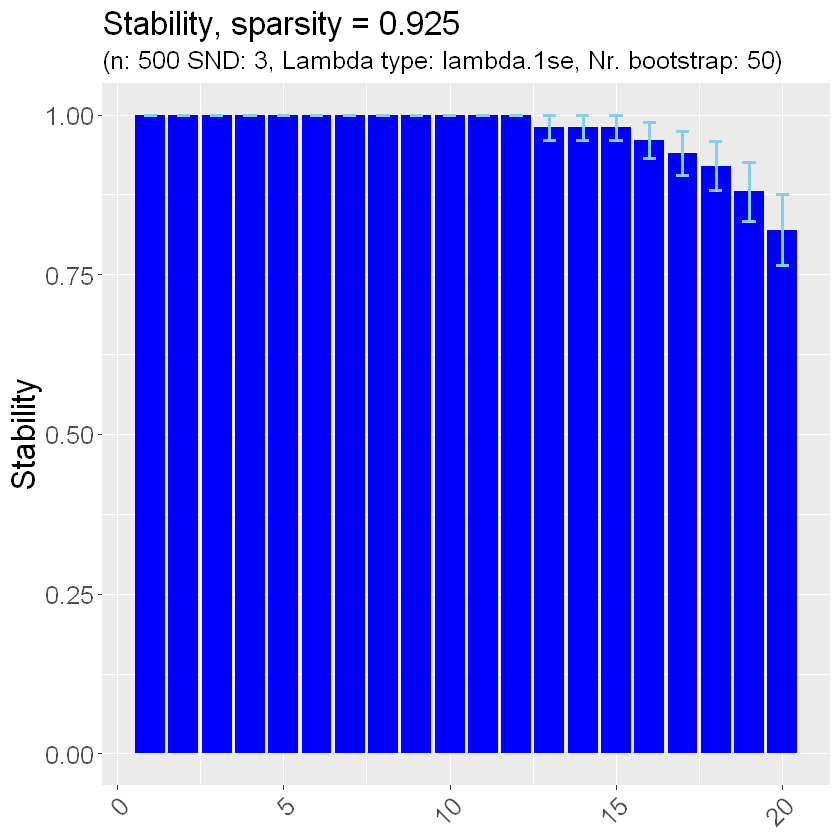

,freq,sd
,<dbl>,<dbl>
V180,50,0.0000000
V819,50,0.0000000
V101,49,0.1414214
V504,47,0.2398979
V5,44,0.3282607
V558,44,0.3282607
V610,44,0.3282607
V358,42,0.3703280
V530,42,0.3703280


,freq,sd
,<dbl>,<dbl>
V57,50,0.0000000
V120,50,0.0000000
V124,50,0.0000000
V288,50,0.0000000
V511,50,0.0000000
V602,50,0.0000000
V632,50,0.0000000
V676,50,0.0000000
V684,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V57,50,0.0000000
V120,50,0.0000000
V124,50,0.0000000
V288,50,0.0000000
V511,50,0.0000000
V602,50,0.0000000
V632,50,0.0000000
V676,50,0.0000000
V684,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V5,50,0
V15,50,0
V18,50,0
V51,50,0
V59,50,0
V68,50,0
V80,50,0
V90,50,0
V97,50,0


,freq,sd
,<dbl>,<dbl>
V6,50,0
V57,50,0
V63,50,0
V79,50,0
V88,50,0
V115,50,0
V120,50,0
V124,50,0
V283,50,0


,freq,sd
,<dbl>,<dbl>
V111,50,0
V177,50,0
V359,50,0
V439,50,0
V638,50,0
V688,50,0
V798,50,0
V989,50,0


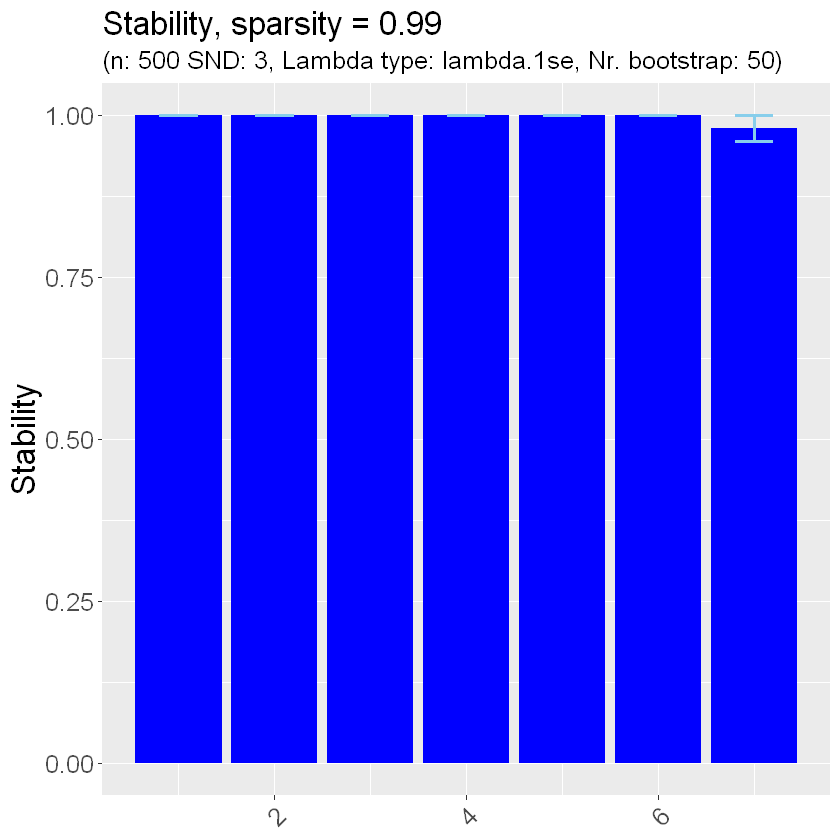

In [5]:

## ---- lambda.1se -------------------------------------------------------------

nz.se.tot.0.75.thresh <- subset(nz.se.tot.0.75, nz.se.tot.0.75$freq > ceiling(M*0.8))
nz.se.tot.0.925.thresh <- subset(nz.se.tot.0.925, nz.se.tot.0.925$freq > ceiling(M*0.8))
nz.se.tot.0.99.thresh <- subset(nz.se.tot.0.99, nz.se.tot.0.99$freq > ceiling(M*0.8))
#nz.true.tot.thresh <- nz.true.tot[nz.se.tot$freq > ceiling(M*0.8)]
## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.0.75.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.75.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.75.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.75",
       subtitle = paste0("(n: ",n," SND: ",SND,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


ggplot((nz.se.tot.0.925.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.925.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.925.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, sparsity = 0.925",
       subtitle = paste0("(n: ",n," SND: ",SND,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 


ggplot((nz.se.tot.0.99.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.0.99.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.0.99.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
 labs(title = "Stability, sparsity = 0.99",
       subtitle = paste0("(n: ",n," SND: ",SND,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 




#A <- cbind(nz.true.tot.thresh, nz.se.tot.thresh)

list(nz.se.tot.0.75.thresh)
list(nz.se.tot.0.925.thresh)
list(nz.se.tot.0.925.thresh)
list(nz.true.tot.0.75)
list(nz.true.tot.0.925)
list(nz.true.tot.0.99)

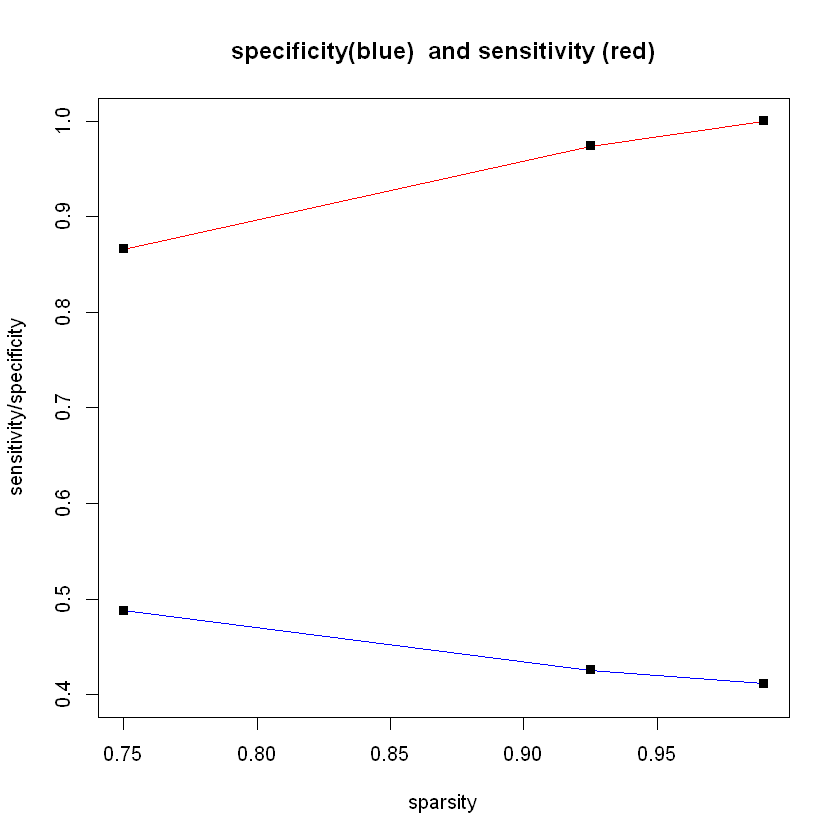

In [6]:
## ---- Comparing true and sparsity --------------------------------------------



specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- u > 0
  
  # Remove all zero entries in v
  u <- u[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  v <- v[non.zero.entries.est]
  
  # non-zero entries in u
  zero.in.true <- v == 0
  
  # Remove all zero entries in what is left of u
  v <- v[zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/(length(u)+length(v))
  
  return <- sens
  
}




spec.1se <- matrix(0, dim(se.beta)[1],1)
sens.1se <- matrix(0, dim(se.beta)[1],1)


for (i in (1:dim(se.beta)[1])){
  
  
  
  spec.1se[i] <- specificity(se.beta[i, ], true.beta[i, ])
  sens.1se[i] <- sensitivity(se.beta[i, ], true.beta[i, ])
  
  
}

dd <- as.data.frame(cbind(spec.1se,sens.1se, c(0.75,0.925,0.99)))

colnames(dd) <- c("spec.1se","sens.1se", "variable")

variable <- as.factor(dd$variable)




# create base scatter plot
plot(dd$variable, dd$spec.1se,
     ylim = c(0.4,1), col='blue', pch=18, type = "l",
     main = "specificity(blue)  and sensitivity (red)",
     xlab = "sparsity", ylab = "sensitivity/specificity")

# overlay scatter plot 
points(dd$variable, dd$sens.1se, col='red', pch=15, type = "l")
points(dd$variable, dd$sens.1se, col='black', pch=15)
points(dd$variable, dd$spec.1se, col='black', pch=15)


In [7]:
A <- as.data.frame(cbind(row.names(nz.true.tot.0.75[c(1:5),]),row.names(nz.se.tot.0.75[c(1:5),]),row.names(nz.true.tot.0.925[c(1:5),]),
                        row.names(nz.se.tot.0.925[c(1:5),]), row.names(nz.true.tot.0.99[c(1:5),]), row.names(nz.se.tot.0.99[c(1:5),])))

colnames(A) <- c("true (0.75)", "lasso (0.75)", "true (0.925)", "lasso (0.925)", "true (0.99)", "lasso (0.99)")
 

A

true (0.75),lasso (0.75),true (0.925),lasso (0.925),true (0.99),lasso (0.99)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
V5,V180,V6,V57,V111,V111
V15,V819,V57,V120,V177,V177
V18,V101,V63,V124,V359,V359
V51,V504,V79,V288,V439,V439
V59,V5,V88,V511,V638,V798


In [2]:



SS <- c(2,3,4) 
n.train <- c(200,500,750)
sparse <- c(0.75,0.925,0.99)


M <- 50

p <- 1000


## ---- SAMPLE SIZE ---------------------------------------------------------------


sparsity <- 0.95 
SND <- SS[2]








min.beta <- matrix(0, length(n.train),p)
se.beta <- matrix(0, length(n.train),p)
true.beta <- matrix(0, length(n.train),p)




# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.

for (l in (1:length(n.train))){
  n <- n.train[l]
  
  # coef.min <- matrix(0, 1,p)
  # coef.1se <- matrix(0, 1,p)
  # coef.true <- matrix(0, 1,p)
  # 
  # 
  beta.min <- matrix(0, 1, p)
  beta.1se <- matrix(0, 1, p)
  beta.true <- matrix(0, 1,p)
  
  # for (j in (1:length(n.train))){
  
  
  
  return <- sim.data.corr(n,p,sparsity,SND)
  
  suppressMessages(attach(return))
  
  
  
  
  
  # Loop to create M bootstrap models
  for ( i in 1:M) {
    
    # The bootstrapped data (replace = T is important!)
    #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
    
    # Row id for bootstrapping
    id <- sample(n, size = n, replace = T)
    
    # Bootstrapped data and labels
    boot.X <- X[id,]
    boot.y <- y[id,]
    
    # Create model for bootstrapped data
    lasso.cv <- cv.glmnet(
      x = boot.X, y = boot.y,
      keep = T,
      alpha = 1,
      type.measure = "mse")
    
    
    #pred.min <- predict(lasso.cv, newx = boot.X, s = "lambda.min")
    pred.1se <- predict(lasso.cv, newx = boot.X, s = "lambda.1se")
    
    #beta.min.1 <- coef(lasso.cv, s = "lambda.min")[-1]
    beta.1se.1 <- coef(lasso.cv, s = "lambda.1se")[-1]
    beta.true.1 <- return$beta
    
    
    
    for ( ll in (1:p)){
      #   
      #   if( beta.min.1[ll] > 0){
      #     
      #     beta.min[ll] <- beta.min[ll] + 1
      #     
      #   }
      if( beta.1se.1[ll] > 0){
        
        beta.1se[ll] <- beta.1se[ll] + 1
        
      }
      if( beta.true.1[ll] > 0){
        
        beta.true[ll] <- beta.true[ll] + 1
        
      }
      
    }
    
    
    
  }
  
  #min.beta[l,] <- beta.min
  se.beta[l,] <- beta.1se
  true.beta[l,] <- beta.true
  
  
}

#min.beta <- as.data.frame(min.beta)
se.beta <- as.data.frame(se.beta)
true.beta <- as.data.frame(true.beta)

# ---- standard deviation ------------------------------------------------------

# sd.selected.min <- as.data.frame(matrix(NA, 
#                                         nrow = dim(min.beta)[1],
#                                         ncol = dim(min.beta)[2],
#                                         dimnames = list(rownames(min.beta),
#                                                         colnames(min.beta))))
sd.selected.1se <- as.data.frame(matrix(NA, 
                                        nrow = dim(min.beta)[1],
                                        ncol = dim(min.beta)[2],
                                        dimnames = list(rownames(min.beta),
                                                        colnames(min.beta))))

sd.selected.true <- as.data.frame(matrix(NA, 
                                         nrow = dim(min.beta)[1],
                                         ncol = dim(min.beta)[2],
                                         dimnames = list(rownames(min.beta),
                                                         colnames(min.beta))))

for ( i in (1:length(sd.selected.1se[,1]))){
  for (j in (1:length(sd.selected.1se[1,]))){
    
    #sd.selected.min[i,j] <- sd(c(rep(0, ((M**length(sparse))-min.beta[i,j])), rep(1, min.beta[i,j])))
    
    sd.selected.1se[i,j] <- sd(c(rep(0, (M-se.beta[i,j])), rep(1, se.beta[i,j])))
    
    sd.selected.true[i,j] <- sd(c(rep(0, (M-true.beta[i,j])), rep(1, true.beta[i,j])))
    
    
  }
}


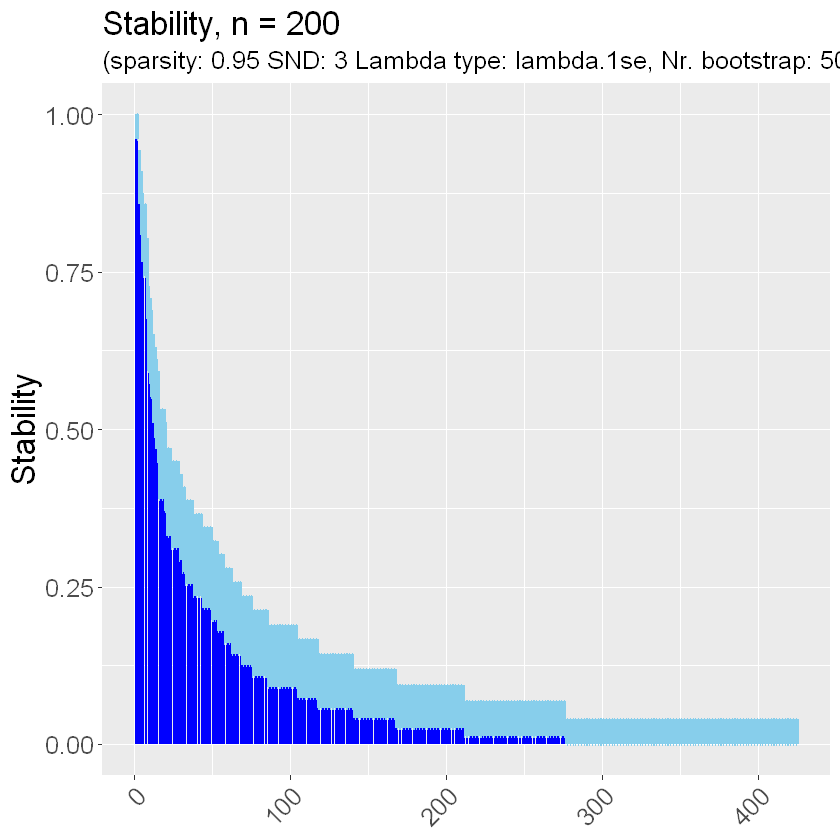

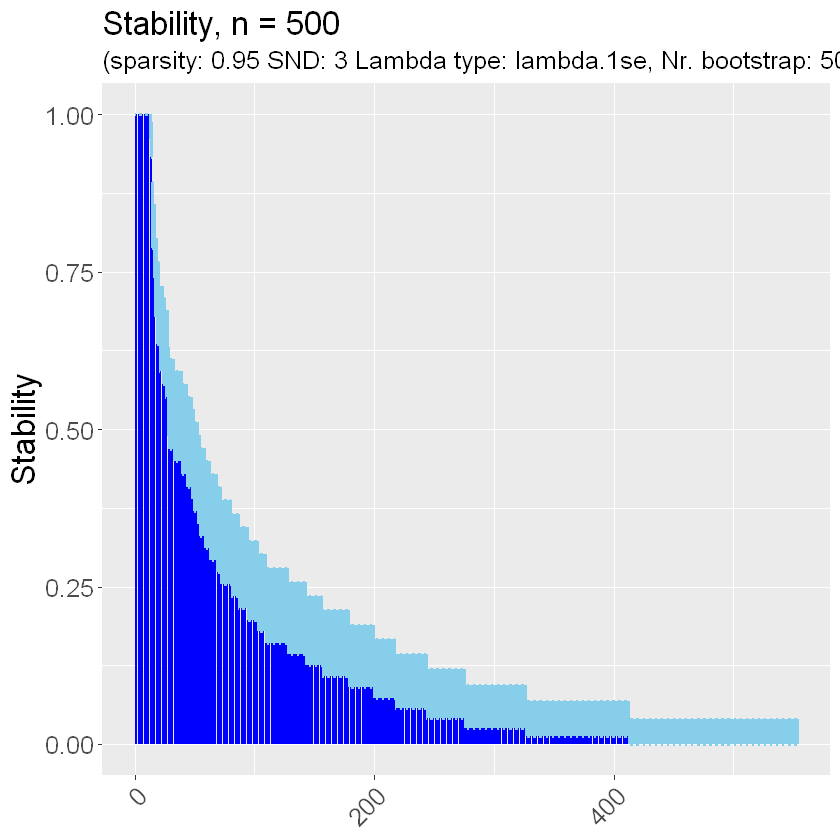

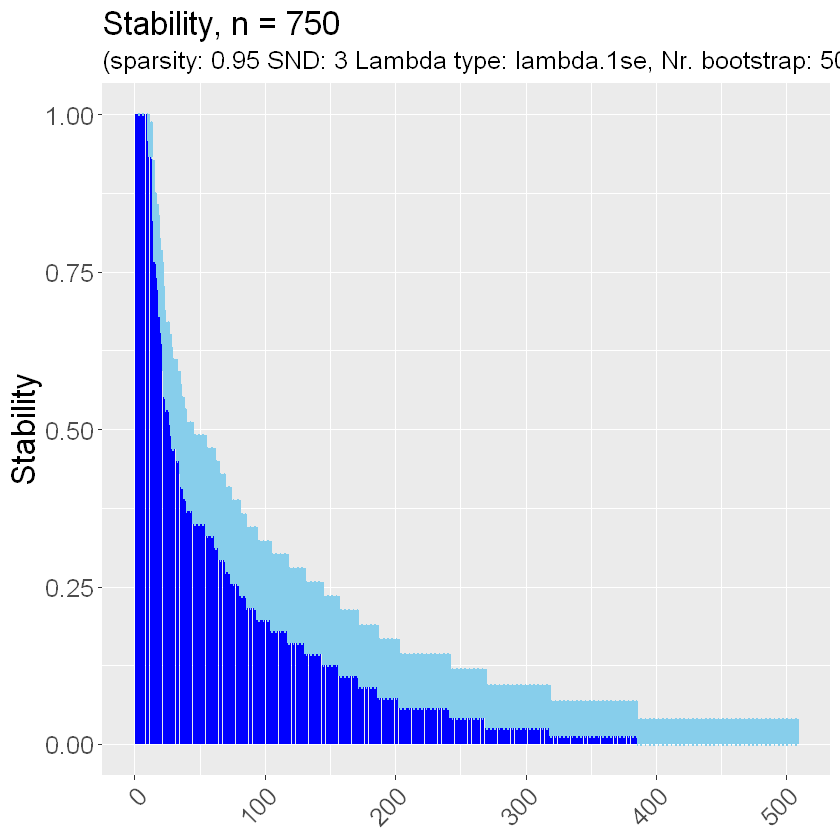

In [3]:

## ---- lambda.1se -------------------------------------------------------------

se.tot.200 <- as.data.frame(cbind((t(se.beta[1,])),t((sd.selected.1se[1,]))))
colnames(se.tot.200) <- c("freq","sd")

nz.se.tot.200 <- subset(se.tot.200, se.tot.200$freq>0)
nz.se.tot.200 <- nz.se.tot.200[order(nz.se.tot.200$freq, decreasing = T),]


se.tot.500 <- as.data.frame(cbind((t(se.beta[2,])),t((sd.selected.1se[2,]))))
colnames(se.tot.500) <- c("freq","sd")

nz.se.tot.500 <- subset(se.tot.500, se.tot.500$freq>0)
nz.se.tot.500 <- nz.se.tot.500[order(nz.se.tot.500$freq, decreasing = T),]


se.tot.750 <- as.data.frame(cbind((t(se.beta[3,])),t((sd.selected.1se[3,]))))
colnames(se.tot.750) <- c("freq","sd")

nz.se.tot.750 <- subset(se.tot.750, se.tot.750$freq>0)
nz.se.tot.750 <- nz.se.tot.750[order(nz.se.tot.750$freq, decreasing = T),]


## ---- lambda.true ------------------------------------------------------------


true.tot.200 <- as.data.frame(cbind((t(true.beta[1,])),t((sd.selected.true[1,]))))
colnames(true.tot.200) <- c("freq","sd")

nz.true.tot.200 <- subset(true.tot.200, true.tot.200$freq>0)
nz.true.tot.200 <- nz.true.tot.200[order(nz.true.tot.200$freq, decreasing = T),]


true.tot.500 <- as.data.frame(cbind((t(true.beta[2,])),t((sd.selected.true[2,]))))
colnames(true.tot.500) <- c("freq","sd")

nz.true.tot.500 <- subset(true.tot.500, true.tot.500$freq>0)
nz.true.tot.500 <- nz.true.tot.500[order(nz.true.tot.500$freq, decreasing = T),]


true.tot.750 <- as.data.frame(cbind((t(true.beta[3,])),t((sd.selected.true[3,]))))
colnames(true.tot.750) <- c("freq","sd")

nz.true.tot.750 <- subset(true.tot.750, true.tot.750$freq>0)
nz.true.tot.750 <- nz.true.tot.750[order(nz.true.tot.750$freq, decreasing = T),]





## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.200)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.200)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.200)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
 labs(title = "Stability, n = 200",
       subtitle = paste0("(sparsity: ",sparsity," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.500)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.500)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.500)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
labs(title = "Stability, n = 500",
       subtitle = paste0("(sparsity: ",sparsity," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.750)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.750)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.750)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
labs(title = "Stability, n = 750",
       subtitle = paste0("(sparsity: ",sparsity," SND: ",SND," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


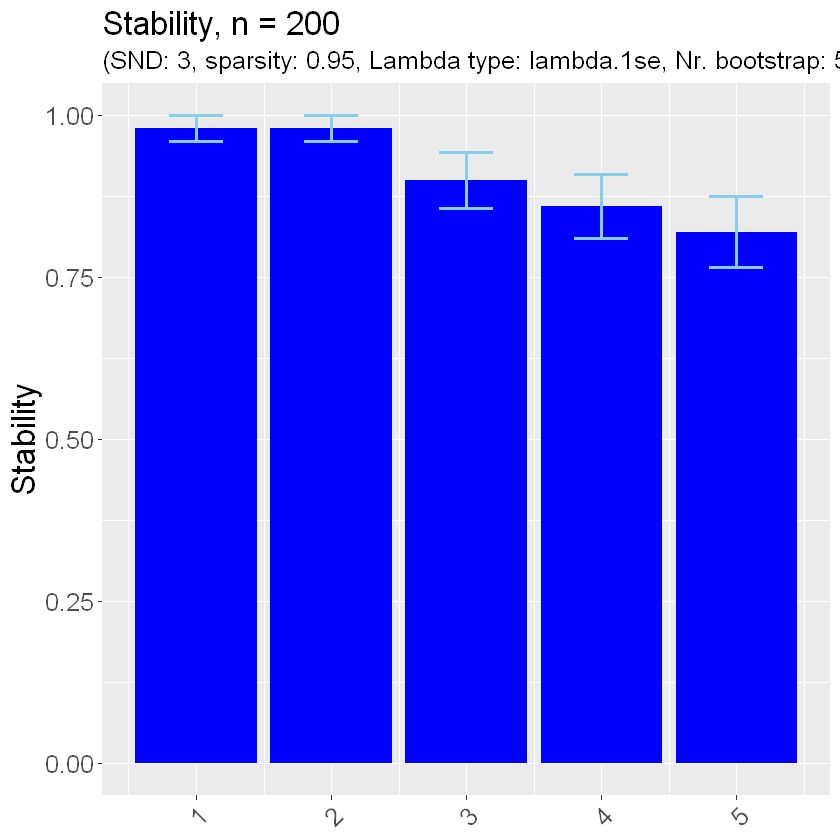

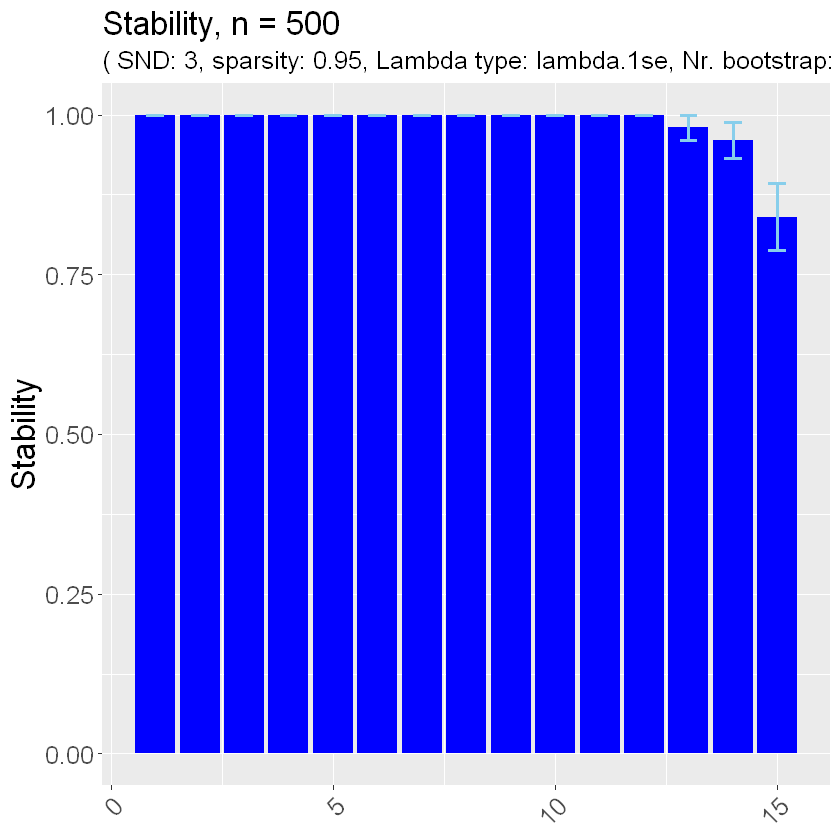

,freq,sd
,<dbl>,<dbl>
V255,49,0.1414214
V664,49,0.1414214
V201,45,0.3030458
V517,43,0.3505098
V137,41,0.3880879


,freq,sd
,<dbl>,<dbl>
V123,50,0.0000000
V166,50,0.0000000
V234,50,0.0000000
V374,50,0.0000000
V391,50,0.0000000
V418,50,0.0000000
V474,50,0.0000000
V544,50,0.0000000
V665,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V62,50,0.0000000
V71,50,0.0000000
V278,50,0.0000000
V415,50,0.0000000
V533,50,0.0000000
V576,50,0.0000000
V717,50,0.0000000
V918,50,0.0000000
V990,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V109,50,0
V137,50,0
V188,50,0
V201,50,0
V214,50,0
V240,50,0
V255,50,0
V304,50,0
V321,50,0


,freq,sd
,<dbl>,<dbl>
V123,50,0
V166,50,0
V171,50,0
V234,50,0
V340,50,0
V351,50,0
V374,50,0
V391,50,0
V418,50,0


,freq,sd
,<dbl>,<dbl>
V15,50,0
V62,50,0
V71,50,0
V87,50,0
V278,50,0
V288,50,0
V415,50,0
V505,50,0
V533,50,0


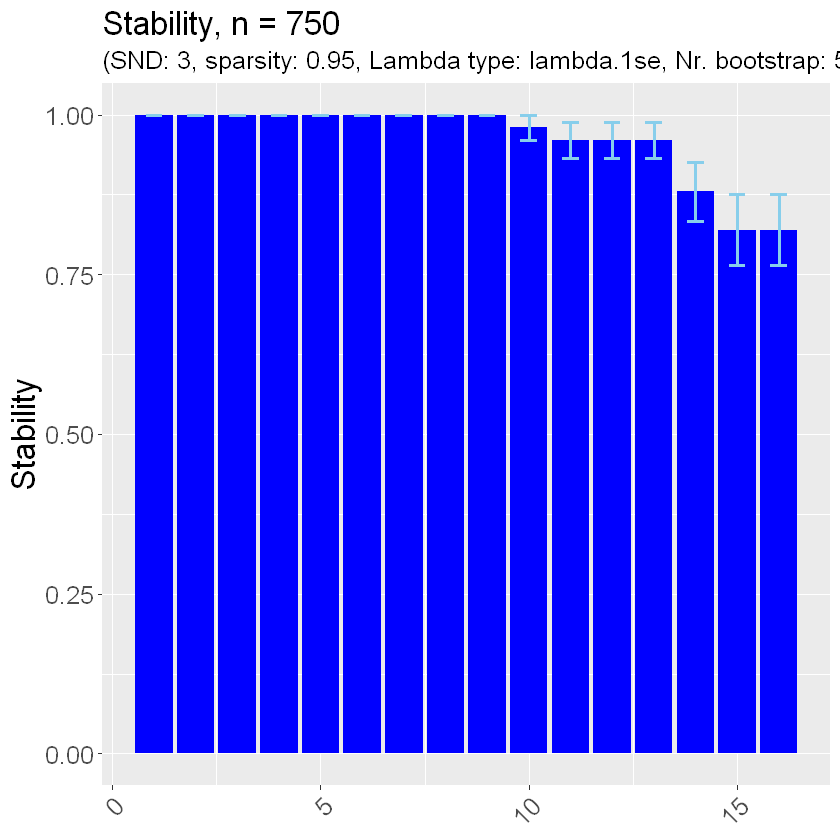

In [6]:

## ---- lambda.1se -------------------------------------------------------------

nz.se.tot.200.thresh <- subset(nz.se.tot.200, nz.se.tot.200$freq > ceiling(M*0.8))
nz.se.tot.500.thresh <- subset(nz.se.tot.500, nz.se.tot.500$freq > ceiling(M*0.8))
nz.se.tot.750.thresh <- subset(nz.se.tot.750, nz.se.tot.750$freq > ceiling(M*0.8))
#nz.true.tot.thresh <- nz.true.tot[nz.se.tot$freq > ceiling(M*0.8)]
## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.200.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.200.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.200.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, n = 200",
       subtitle = paste0("(SND: ",SND,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


ggplot((nz.se.tot.500.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.500.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.500.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, n = 500",
       subtitle = paste0("( SND: ",SND,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 


ggplot((nz.se.tot.750.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.750.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.750.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, n = 750",
       subtitle = paste0("(SND: ",SND,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 




#A <- cbind(nz.true.tot.thresh, nz.se.tot.thresh)

list(nz.se.tot.200.thresh)
list(nz.se.tot.500.thresh)
list(nz.se.tot.750.thresh)
list(nz.true.tot.200)
list(nz.true.tot.500)
list(nz.true.tot.750)

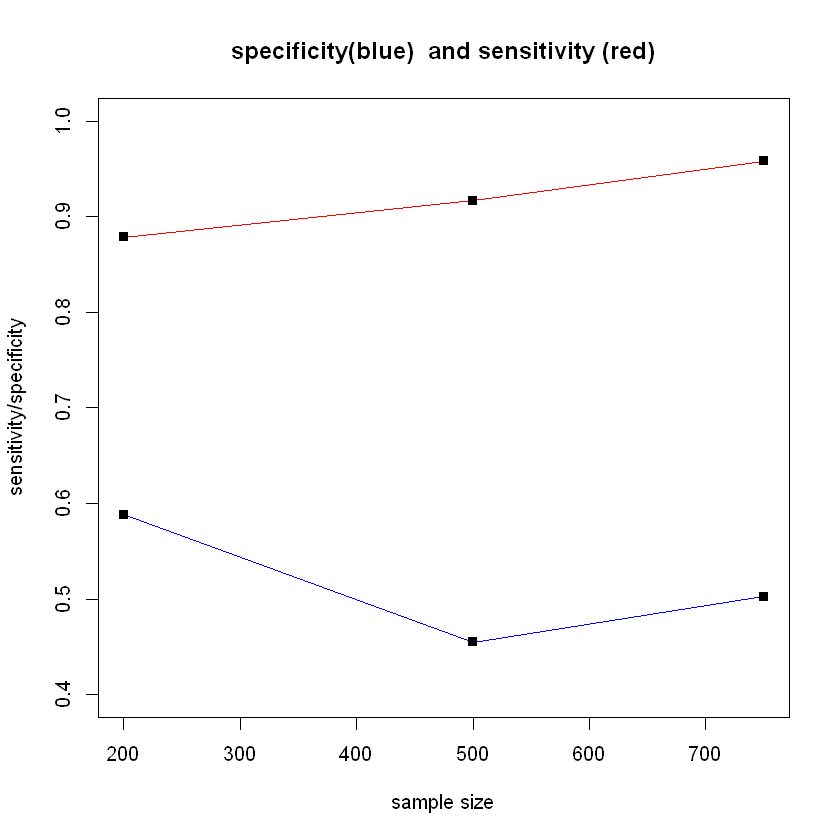

In [7]:
## ---- Comparing true and sparsity --------------------------------------------



specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- u > 0
  
  # Remove all zero entries in v
  u <- u[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  v <- v[non.zero.entries.est]
  
  # non-zero entries in u
  zero.in.true <- v == 0
  
  # Remove all zero entries in what is left of u
  v <- v[zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/(length(u)+length(v))
  
  return <- sens
  
}




spec.1se <- matrix(0, dim(se.beta)[1],1)
sens.1se <- matrix(0, dim(se.beta)[1],1)


for (i in (1:dim(se.beta)[1])){
  
  
  
  spec.1se[i] <- specificity(se.beta[i, ], true.beta[i, ])
  sens.1se[i] <- sensitivity(se.beta[i, ], true.beta[i, ])
  
  
}

dd <- as.data.frame(cbind(spec.1se,sens.1se, c(200,500,750)))

colnames(dd) <- c("spec.1se","sens.1se", "variable")

variable <- as.factor(dd$variable)




# create base scatter plot
plot(dd$variable, dd$spec.1se,
     ylim = c(0.4,1), col='blue', pch=18, type = "l",
     main = "specificity(blue)  and sensitivity (red)",
     xlab = "sample size", ylab = "sensitivity/specificity")

# overlay scatter plot 
points(dd$variable, dd$sens.1se, col='red', pch=15, type = "l")
points(dd$variable, dd$sens.1se, col='black', pch=15)
points(dd$variable, dd$spec.1se, col='black', pch=15)


In [8]:
A <- as.data.frame(cbind(row.names(nz.true.tot.200[c(1:5),]),row.names(nz.se.tot.200[c(1:5),]),row.names(nz.true.tot.500[c(1:5),]),
                        row.names(nz.se.tot.500[c(1:5),]), row.names(nz.true.tot.750[c(1:5),]), row.names(nz.se.tot.750[c(1:5),])))

colnames(A) <- c("true (200)", "lasso (200)", "true (500)", "lasso (500)", "true (750)", "lasso (750)")
 

A

true (200),lasso (200),true (500),lasso (500),true (750),lasso (750)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
V109,V255,V123,V123,V15,V62
V137,V664,V166,V166,V62,V71
V188,V201,V171,V234,V71,V278
V201,V517,V234,V374,V87,V415
V214,V137,V340,V391,V278,V533


In [2]:


library(MASS)

ss <- c(2,3,4) 
n.train <- c(200,500,750)
sparse <- c(0.75,0.925,0.99)


M <- 50

p <- 1000


## ---- SIGNAL STRENGTH ---------------------------------------------------------------


sparsity <- 0.925
n <- n.train[2]








min.beta <- matrix(0, length(ss),p)
se.beta <- matrix(0, length(ss),p)
true.beta <- matrix(0, length(ss),p)




# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.

for (l in (1:length(ss))){
  SND <- ss[l]
  
  # coef.min <- matrix(0, 1,p)
  # coef.1se <- matrix(0, 1,p)
  # coef.true <- matrix(0, 1,p)
  # 
  # 
  beta.min <- matrix(0, 1, p)
  beta.1se <- matrix(0, 1, p)
  beta.true <- matrix(0, 1,p)
  
  # for (j in (1:length(n.train))){
  
  
  
  return <- sim.data.corr(n,p,sparsity,SND)
  
  suppressMessages(attach(return))
  
  
  
  
  
  # Loop to create M bootstrap models
  for ( i in 1:M) {
    
    # The bootstrapped data (replace = T is important!)
    #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
    
    # Row id for bootstrapping
    id <- sample(n, size = n, replace = T)
    
    # Bootstrapped data and labels
    boot.X <- X[id,]
    boot.y <- y[id,]
    
    # Create model for bootstrapped data
    lasso.cv <- cv.glmnet(
      x = boot.X, y = boot.y,
      keep = T,
      alpha = 1,
      type.measure = "mse")
    
    
    #pred.min <- predict(lasso.cv, newx = boot.X, s = "lambda.min")
    pred.1se <- predict(lasso.cv, newx = boot.X, s = "lambda.1se")
    
    #beta.min.1 <- coef(lasso.cv, s = "lambda.min")[-1]
    beta.1se.1 <- coef(lasso.cv, s = "lambda.1se")[-1]
    beta.true.1 <- return$beta
    
    
    
    for ( ll in (1:p)){
      #   
      #   if( beta.min.1[ll] > 0){
      #     
      #     beta.min[ll] <- beta.min[ll] + 1
      #     
      #   }
      if( beta.1se.1[ll] > 0){
        
        beta.1se[ll] <- beta.1se[ll] + 1
        
      }
      if( beta.true.1[ll] > 0){
        
        beta.true[ll] <- beta.true[ll] + 1
        
      }
      
    }
    
    
    
  }
  
  #min.beta[l,] <- beta.min
  se.beta[l,] <- beta.1se
  true.beta[l,] <- beta.true
  
  
}

#min.beta <- as.data.frame(min.beta)
se.beta <- as.data.frame(se.beta)
true.beta <- as.data.frame(true.beta)

# ---- standard deviation ------------------------------------------------------

# sd.selected.min <- as.data.frame(matrix(NA, 
#                                         nrow = dim(min.beta)[1],
#                                         ncol = dim(min.beta)[2],
#                                         dimnames = list(rownames(min.beta),
#                                                         colnames(min.beta))))
sd.selected.1se <- as.data.frame(matrix(NA, 
                                        nrow = dim(min.beta)[1],
                                        ncol = dim(min.beta)[2],
                                        dimnames = list(rownames(min.beta),
                                                        colnames(min.beta))))

sd.selected.true <- as.data.frame(matrix(NA, 
                                         nrow = dim(min.beta)[1],
                                         ncol = dim(min.beta)[2],
                                         dimnames = list(rownames(min.beta),
                                                         colnames(min.beta))))

for ( i in (1:length(sd.selected.1se[,1]))){
  for (j in (1:length(sd.selected.1se[1,]))){
    
    #sd.selected.min[i,j] <- sd(c(rep(0, ((M**length(sparse))-min.beta[i,j])), rep(1, min.beta[i,j])))
    
    sd.selected.1se[i,j] <- sd(c(rep(0, (M-se.beta[i,j])), rep(1, se.beta[i,j])))
    
    sd.selected.true[i,j] <- sd(c(rep(0, (M-true.beta[i,j])), rep(1, true.beta[i,j])))
    
    
  }
}


Warning message:
"package 'MASS' was built under R version 4.1.3"

Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




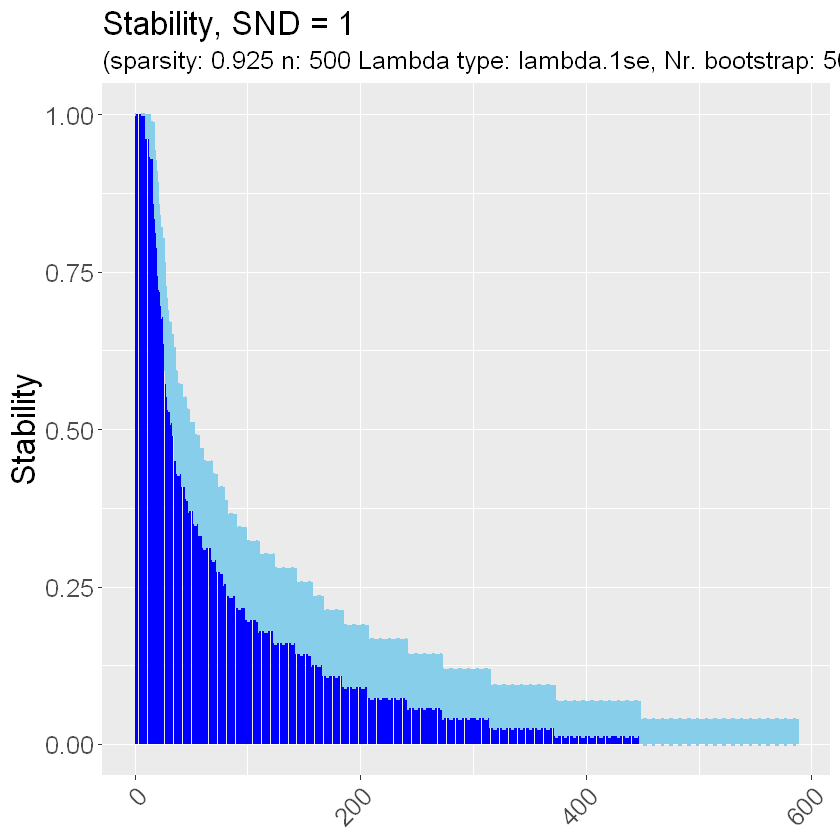

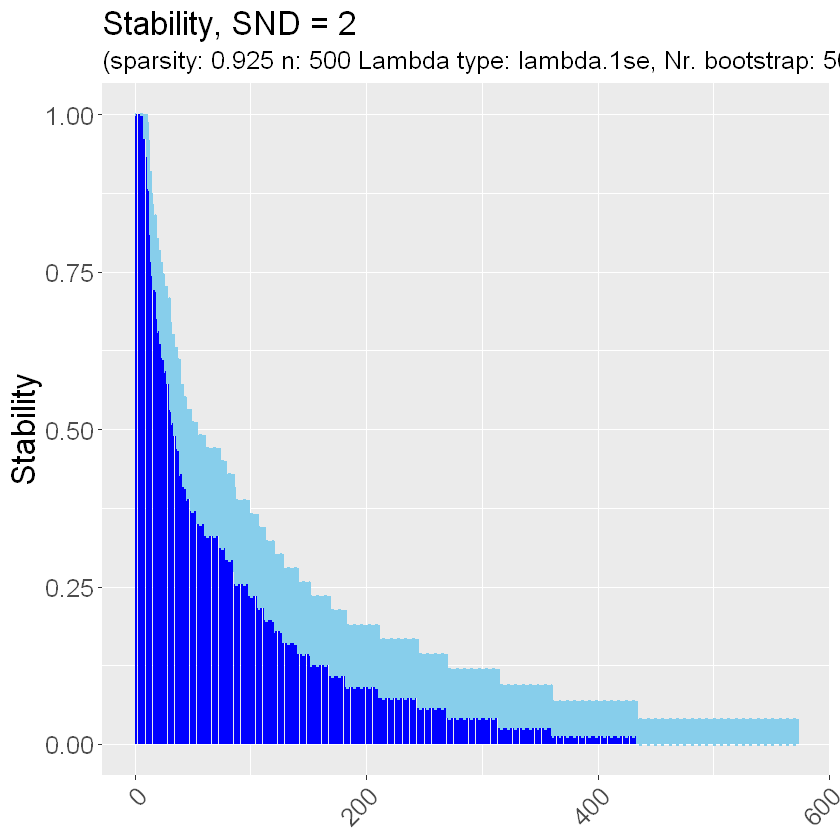

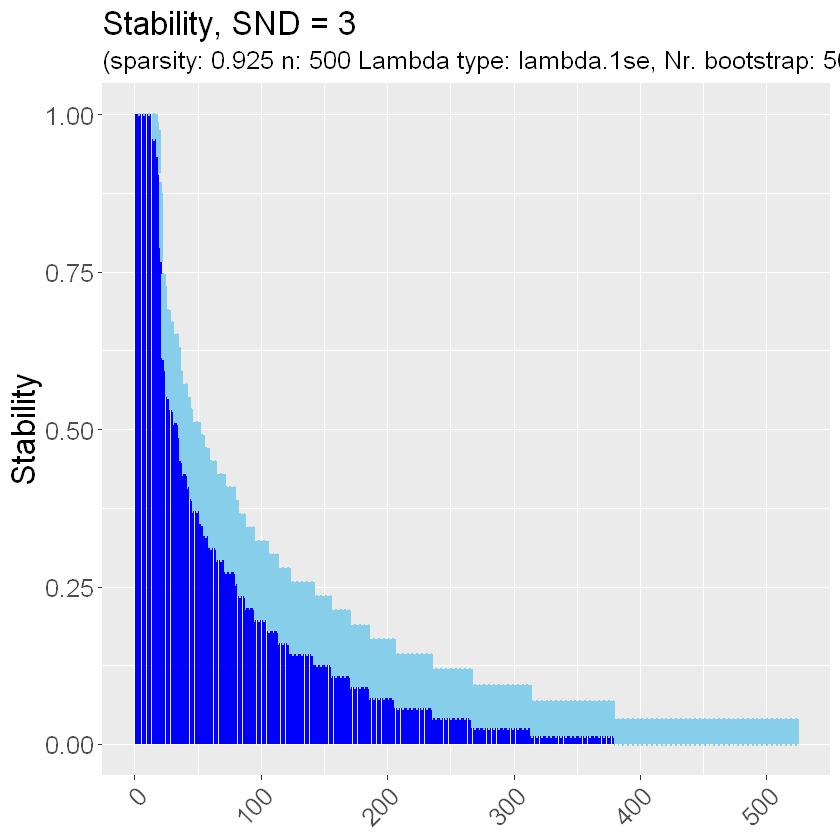

In [4]:

## ---- lambda.1se -------------------------------------------------------------

se.tot.1 <- as.data.frame(cbind((t(se.beta[1,])),t((sd.selected.1se[1,]))))
colnames(se.tot.1) <- c("freq","sd")

nz.se.tot.1 <- subset(se.tot.1, se.tot.1$freq>0)
nz.se.tot.1 <- nz.se.tot.1[order(nz.se.tot.1$freq, decreasing = T),]

se.tot.2 <- as.data.frame(cbind((t(se.beta[2,])),t((sd.selected.1se[2,]))))
colnames(se.tot.2) <- c("freq","sd")

nz.se.tot.2 <- subset(se.tot.2, se.tot.2$freq>0)
nz.se.tot.2 <- nz.se.tot.2[order(nz.se.tot.2$freq, decreasing = T),]

se.tot.3 <- as.data.frame(cbind((t(se.beta[3,])),t((sd.selected.1se[3,]))))
colnames(se.tot.3) <- c("freq","sd")

nz.se.tot.3 <- subset(se.tot.3, se.tot.3$freq>0)
nz.se.tot.3 <- nz.se.tot.3[order(nz.se.tot.3$freq, decreasing = T),]

## ---- lambda.true ------------------------------------------------------------


true.tot.2 <- as.data.frame(cbind((t(true.beta[1,])),t((sd.selected.true[1,]))))
colnames(true.tot.2) <- c("freq","sd")

nz.true.tot.2 <- subset(true.tot.2, true.tot.2$freq>0)
nz.true.tot.2 <- nz.true.tot.2[order(nz.true.tot.2$freq, decreasing = T),]


true.tot.3 <- as.data.frame(cbind((t(true.beta[2,])),t((sd.selected.true[2,]))))
colnames(true.tot.3) <- c("freq","sd")

nz.true.tot.3 <- subset(true.tot.3, true.tot.3$freq>0)
nz.true.tot.3 <- nz.true.tot.3[order(nz.true.tot.3$freq, decreasing = T),]


true.tot.4 <- as.data.frame(cbind((t(true.beta[3,])),t((sd.selected.true[3,]))))
colnames(true.tot.4) <- c("freq","sd")

nz.true.tot.4 <- subset(true.tot.4, true.tot.4$freq>0)
nz.true.tot.4 <- nz.true.tot.4[order(nz.true.tot.4$freq, decreasing = T),]





## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.1)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.1)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.1)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, SND = 1",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.2)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.2)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.2)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, SND = 2",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot.3)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.3)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.3)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
labs(title = "Stability, SND = 3",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))



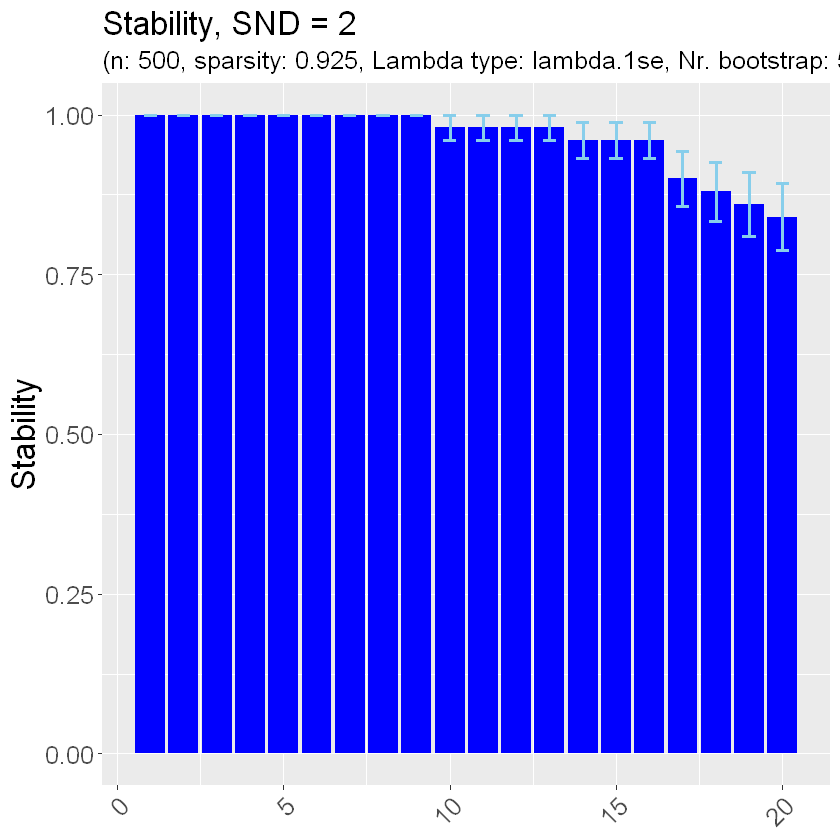

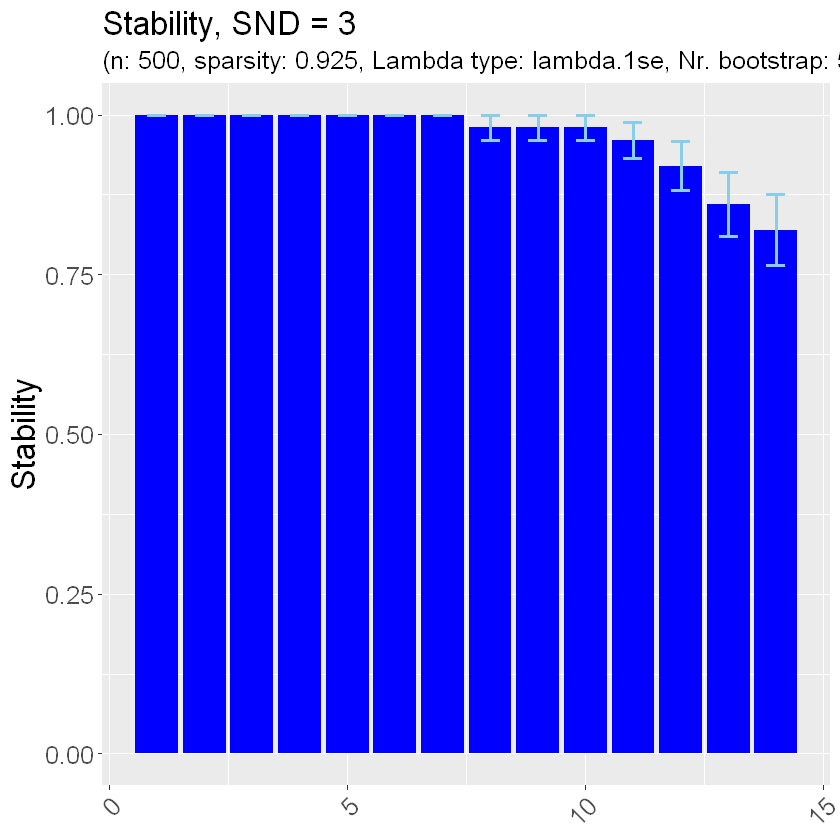

,freq,sd
,<dbl>,<dbl>
V122,50,0.0000000
V145,50,0.0000000
V300,50,0.0000000
V436,50,0.0000000
V596,50,0.0000000
V617,50,0.0000000
V805,50,0.0000000
V844,50,0.0000000
V873,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V271,50,0.0000000
V458,50,0.0000000
V463,50,0.0000000
V548,50,0.0000000
V573,50,0.0000000
V610,50,0.0000000
V881,50,0.0000000
V399,49,0.1414214
V943,49,0.1414214


,freq,sd
,<dbl>,<dbl>
V27,50,0.0000000
V32,50,0.0000000
V78,50,0.0000000
V83,50,0.0000000
V261,50,0.0000000
V275,50,0.0000000
V306,50,0.0000000
V460,50,0.0000000
V476,50,0.0000000


,freq,sd
,<dbl>,<dbl>
V6,50,0
V10,50,0
V38,50,0
V61,50,0
V91,50,0
V122,50,0
V136,50,0
V145,50,0
V225,50,0


,freq,sd
,<dbl>,<dbl>
V2,50,0
V15,50,0
V20,50,0
V112,50,0
V126,50,0
V165,50,0
V186,50,0
V271,50,0
V285,50,0


,freq,sd
,<dbl>,<dbl>
V27,50,0
V30,50,0
V32,50,0
V78,50,0
V83,50,0
V153,50,0
V176,50,0
V195,50,0
V198,50,0


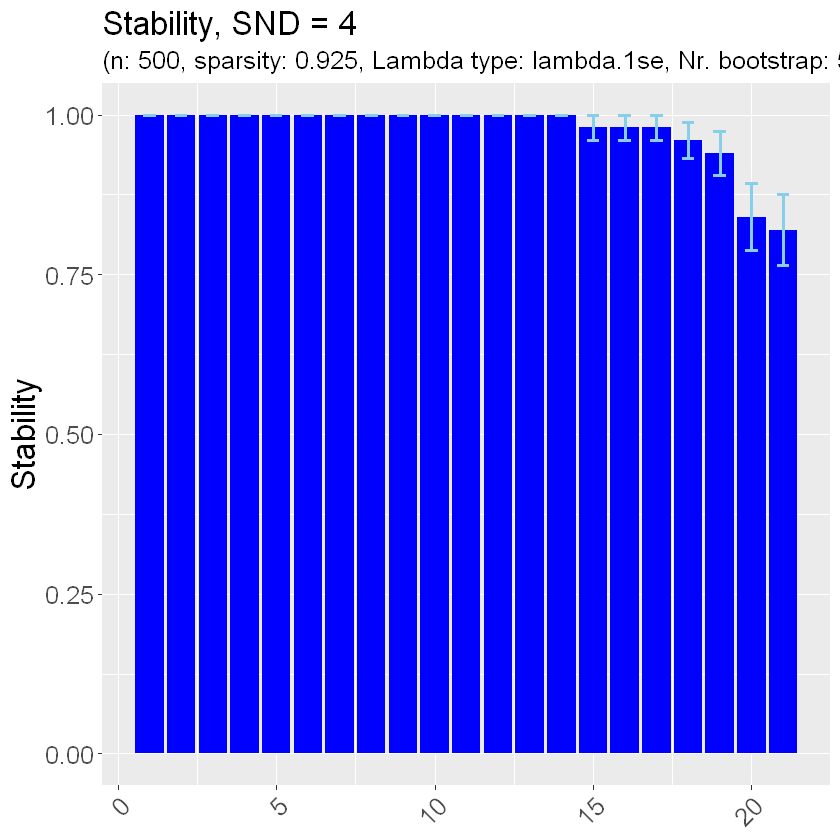

In [5]:

## ---- lambda.1se -------------------------------------------------------------

nz.se.tot.2.thresh <- subset(nz.se.tot.1, nz.se.tot.1$freq > ceiling(M*0.8))
nz.se.tot.3.thresh <- subset(nz.se.tot.2, nz.se.tot.2$freq > ceiling(M*0.8))
nz.se.tot.4.thresh <- subset(nz.se.tot.3, nz.se.tot.3$freq > ceiling(M*0.8))
#nz.true.tot.thresh <- nz.true.tot[nz.se.tot$freq > ceiling(M*0.8)]
## ---- plotting ---------------------------------------------------------------

ggplot((nz.se.tot.2.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.2.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.2.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, SND = 2",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


ggplot((nz.se.tot.3.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.3.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.3.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, SND = 3",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 


ggplot((nz.se.tot.4.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.4.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.4.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, SND = 4",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", Lambda type: lambda.1se, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 




#A <- cbind(nz.true.tot.thresh, nz.se.tot.thresh)

list(nz.se.tot.2.thresh)
list(nz.se.tot.3.thresh)
list(nz.se.tot.4.thresh)
list(nz.true.tot.2)
list(nz.true.tot.3)
list(nz.true.tot.4)

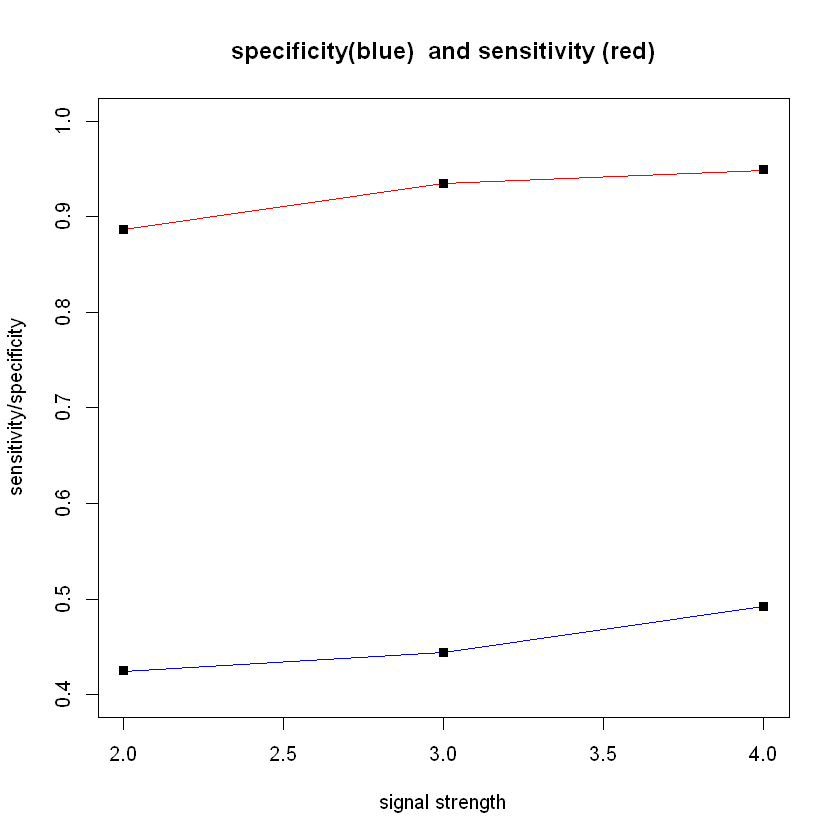

In [6]:
## ---- Comparing true and sparsity --------------------------------------------



specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- u > 0
  
  # Remove all zero entries in v
  u <- u[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  v <- v[non.zero.entries.est]
  
  # non-zero entries in u
  zero.in.true <- v == 0
  
  # Remove all zero entries in what is left of u
  v <- v[zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/(length(u)+length(v))
  
  return <- sens
  
}




spec.1se <- matrix(0, dim(se.beta)[1],1)
sens.1se <- matrix(0, dim(se.beta)[1],1)


for (i in (1:dim(se.beta)[1])){
  
  
  
  spec.1se[i] <- specificity(se.beta[i, ], true.beta[i, ])
  sens.1se[i] <- sensitivity(se.beta[i, ], true.beta[i, ])
  
  
}

dd <- as.data.frame(cbind(spec.1se,sens.1se, c(2,3,4)))

colnames(dd) <- c("spec.1se","sens.1se", "variable")

variable <- as.factor(dd$variable)




# create base scatter plot
plot(dd$variable, dd$spec.1se,
     ylim = c(0.4,1), col='blue', pch=18, type = "l",
     main = "specificity(blue)  and sensitivity (red)",
     xlab = "signal strength", ylab = "sensitivity/specificity")

# overlay scatter plot 
points(dd$variable, dd$sens.1se, col='red', pch=15, type = "l")
points(dd$variable, dd$sens.1se, col='black', pch=15)
points(dd$variable, dd$spec.1se, col='black', pch=15)


In [8]:
A <- as.data.frame(cbind(row.names(nz.true.tot.2[c(1:5),]),row.names(nz.se.tot.1[c(1:5),]),row.names(nz.true.tot.3[c(1:5),]),
                        row.names(nz.se.tot.2[c(1:5),]), row.names(nz.true.tot.4[c(1:5),]), row.names(nz.se.tot.3[c(1:5),])))

colnames(A) <- c("true (2)", "lasso (2)", "true (3)", "lasso (3)", "true (4)", "lasso (4)")
 

A

true (2),lasso (2),true (3),lasso (3),true (4),lasso (4)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
V6,V122,V2,V271,V27,V27
V10,V145,V15,V458,V30,V32
V38,V300,V20,V463,V32,V78
V61,V436,V112,V548,V78,V83
V91,V596,V126,V573,V83,V261


In [2]:


library(MASS)

ss <- c(1,2,3) 
n.train <- c(200,500,750)
sparse <- c(0.75,0.925,0.99)


M <- 50

p <- 1000


## ---- LAMBDA ---------------------------------------------------------------


sparsity <- 0.925 
n <- n.train[2]
SND <- 2







min.beta <- matrix(0, 1,p)
se.beta <- matrix(0, 1,p)
true.beta <- matrix(0, 1,p)




# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.

# for (l in (1:length(ss))){
#   SND <- ss[l]
  
  # coef.min <- matrix(0, 1,p)
  # coef.1se <- matrix(0, 1,p)
  # coef.true <- matrix(0, 1,p)
  # 
  # 
  beta.min <- matrix(0, 1, p)
  beta.1se <- matrix(0, 1, p)
  beta.max <- matrix(0,1,p)
  beta.true <- matrix(0, 1,p)
  
  # for (j in (1:length(n.train))){
  
  
  
  return <- sim.data.corr(n,p,sparsity,SND)
  
  suppressMessages(attach(return))
  
  
  
  
  
  # Loop to create M bootstrap models
  for ( i in 1:M) {
    
    # The bootstrapped data (replace = T is important!)
    #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
    
    # Row id for bootstrapping
    id <- sample(n, size = n, replace = T)
    
    # Bootstrapped data and labels
    boot.X <- X[id,]
    boot.y <- y[id,]
    
    # Create model for bootstrapped data
    lasso.cv <- cv.glmnet(
      x = boot.X, y = boot.y,
      keep = T,
      alpha = 1,
      type.measure = "mse")
    
    
    pred.min <- predict(lasso.cv, newx = boot.X, s = lasso.cv$lambda.1se/5)
    pred.1se <- predict(lasso.cv, newx = boot.X, s = "lambda.1se")
    pred.max <- predict(lasso.cv, newx = boot.X, s = 5*lasso.cv$lambda.1se)
    
    
    beta.min.1 <- coef(lasso.cv, s = lasso.cv$lambda.1se/5)[-1]
    beta.1se.1 <- coef(lasso.cv, s = "lambda.1se")[-1]
    beta.max.1 <- coef(lasso.cv, s = 5*lasso.cv$lambda.1se)[-1]
    beta.true.1 <- return$beta
    
    
    
    for ( ll in (1:p)){
        
         if( beta.min.1[ll] > 0){
          
           beta.min[ll] <- beta.min[ll] + 1
           
         }
      if( beta.1se.1[ll] > 0){
        
        beta.1se[ll] <- beta.1se[ll] + 1
        
      }
      if( beta.max.1[ll] > 0){
        
        beta.max[ll] <- beta.max[ll] + 1
        
      }
      if( beta.true.1[ll] > 0){
        
        beta.true[ll] <- beta.true[ll] + 1
        
      }
      
    }
    
    
    
  }
  
   min.beta <- beta.min
   se.beta <- beta.1se
   max.beta <- beta.min
  # 
  # 
   true.beta <- beta.true
  
  
#}

min.beta <- as.data.frame(min.beta)
max.beta <- as.data.frame(max.beta)
se.beta <- as.data.frame(se.beta)
true.beta <- as.data.frame(true.beta)

# ---- standard deviation ------------------------------------------------------

 sd.selected.min <- as.data.frame(matrix(NA, 
                                         nrow = dim(min.beta)[1],
                                         ncol = dim(min.beta)[2],
                                         dimnames = list(rownames(min.beta),
                                                         colnames(min.beta))))
sd.selected.1se <- as.data.frame(matrix(NA, 
                                        nrow = dim(min.beta)[1],
                                        ncol = dim(min.beta)[2],
                                        dimnames = list(rownames(min.beta),
                                                        colnames(min.beta))))
sd.selected.max <- as.data.frame(matrix(NA, 
                                        nrow = dim(max.beta)[1],
                                        ncol = dim(max.beta)[2],
                                        dimnames = list(rownames(max.beta),
                                                        colnames(max.beta))))



sd.selected.true <- as.data.frame(matrix(NA, 
                                         nrow = dim(min.beta)[1],
                                         ncol = dim(min.beta)[2],
                                         dimnames = list(rownames(min.beta),
                                                         colnames(min.beta))))

for ( i in (1:length(sd.selected.1se[,1]))){
  for (j in (1:length(sd.selected.1se[1,]))){
    
    sd.selected.min[i,j] <- sd(c(rep(0, (M-min.beta[i,j])), rep(1, min.beta[i,j])))
    
    sd.selected.1se[i,j] <- sd(c(rep(0, (M-se.beta[i,j])), rep(1, se.beta[i,j])))
    
    sd.selected.max[i,j] <- sd(c(rep(0, (M-max.beta[i,j])), rep(1, max.beta[i,j])))
    
    sd.selected.true[i,j] <- sd(c(rep(0, (M-true.beta[i,j])), rep(1, true.beta[i,j])))
    
    
  }
}


Warning message:
"package 'MASS' was built under R version 4.1.3"

Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




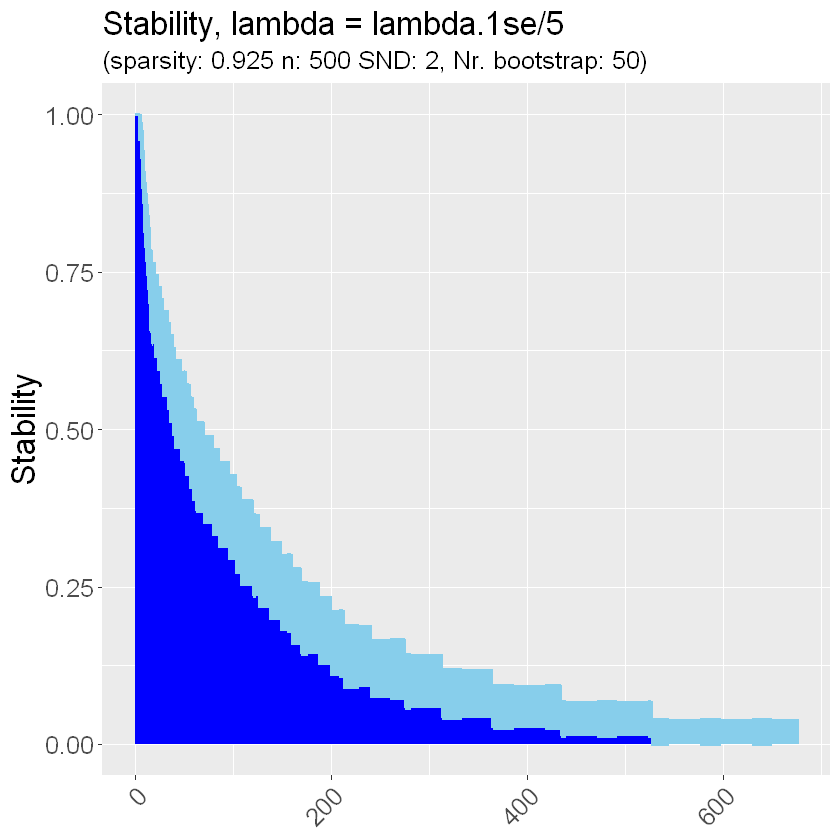

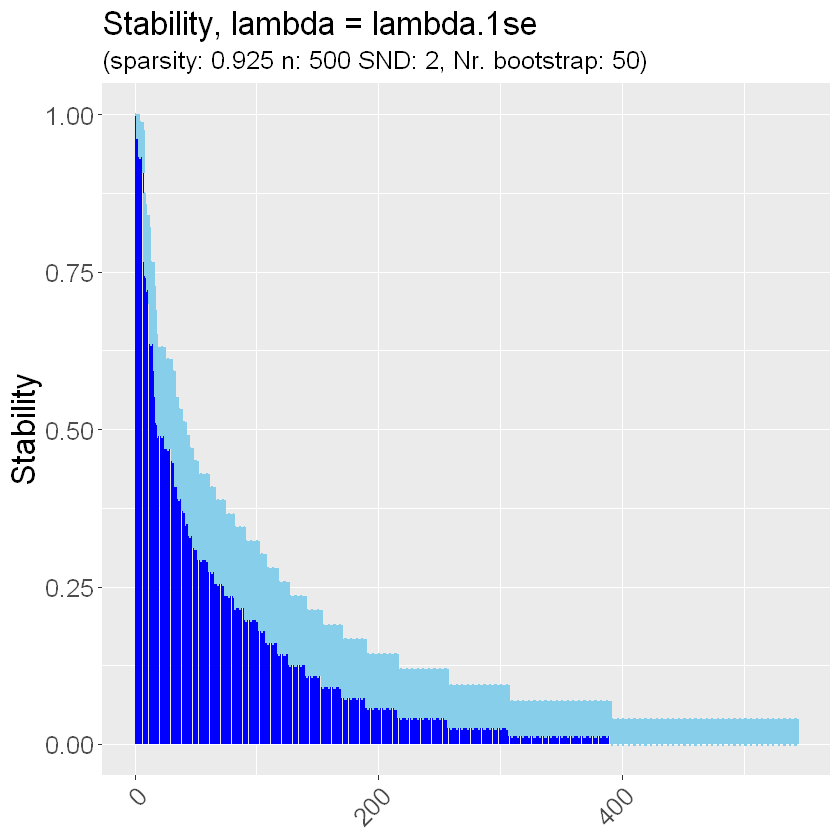

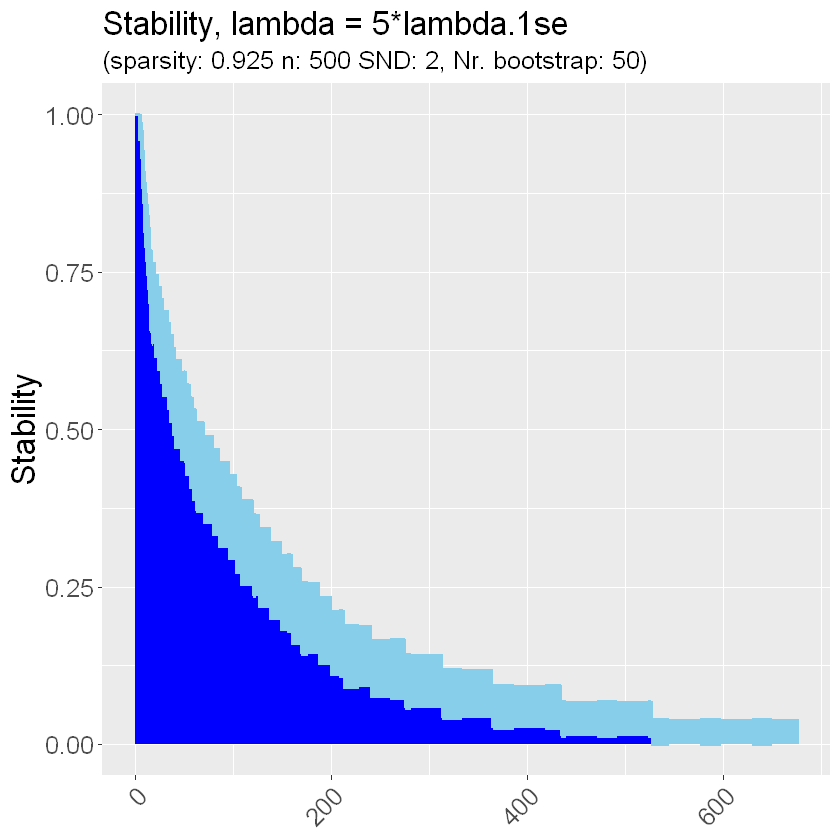

In [3]:

## ---- lambda.1se -------------------------------------------------------------

tot.min <- as.data.frame(cbind((t(min.beta)),t((sd.selected.min))))
colnames(tot.min) <- c("freq","sd")

nz.min.tot <- subset(tot.min, tot.min$freq>0)
nz.min.tot <- nz.min.tot[order(nz.min.tot$freq, decreasing = T),]

se.tot <- as.data.frame(cbind((t(se.beta)),t((sd.selected.1se))))
colnames(se.tot) <- c("freq","sd")

nz.se.tot <- subset(se.tot, se.tot$freq>0)
nz.se.tot <- nz.se.tot[order(nz.se.tot$freq, decreasing = T),]

max.tot <- as.data.frame(cbind((t(max.beta)),t((sd.selected.max))))
colnames(max.tot) <- c("freq","sd")

nz.max.tot <- subset(max.tot, max.tot$freq>0)
nz.max.tot <- nz.max.tot[order(nz.max.tot$freq, decreasing = T),]

true.tot <- as.data.frame(cbind((t(true.beta)),t((sd.selected.true))))
colnames(true.tot) <- c("freq","sd")

nz.true.tot <- subset(true.tot, true.tot$freq>0)
nz.true.tot <- nz.true.tot[order(nz.true.tot$freq, decreasing = T),]




## ---- plotting ---------------------------------------------------------------

ggplot((nz.min.tot)) +
  geom_bar(aes(x = c(1:dim(nz.min.tot)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.min.tot)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
 labs(title = "Stability, lambda = lambda.1se/5",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," SND: 2, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.se.tot)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
 labs(title = "Stability, lambda = lambda.1se",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," SND: 2, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))

ggplot((nz.max.tot)) +
  geom_bar(aes(x = c(1:dim(nz.max.tot)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.max.tot)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
 labs(title = "Stability, lambda = 5*lambda.1se",
       subtitle = paste0("(sparsity: ",sparsity," n: ",n," SND: 2, Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))



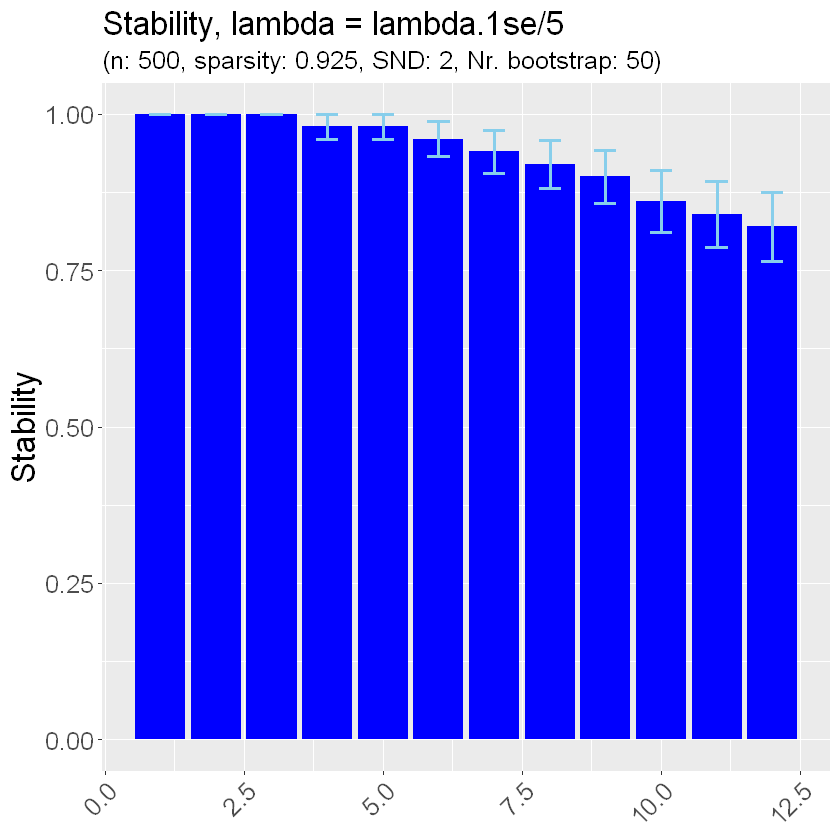

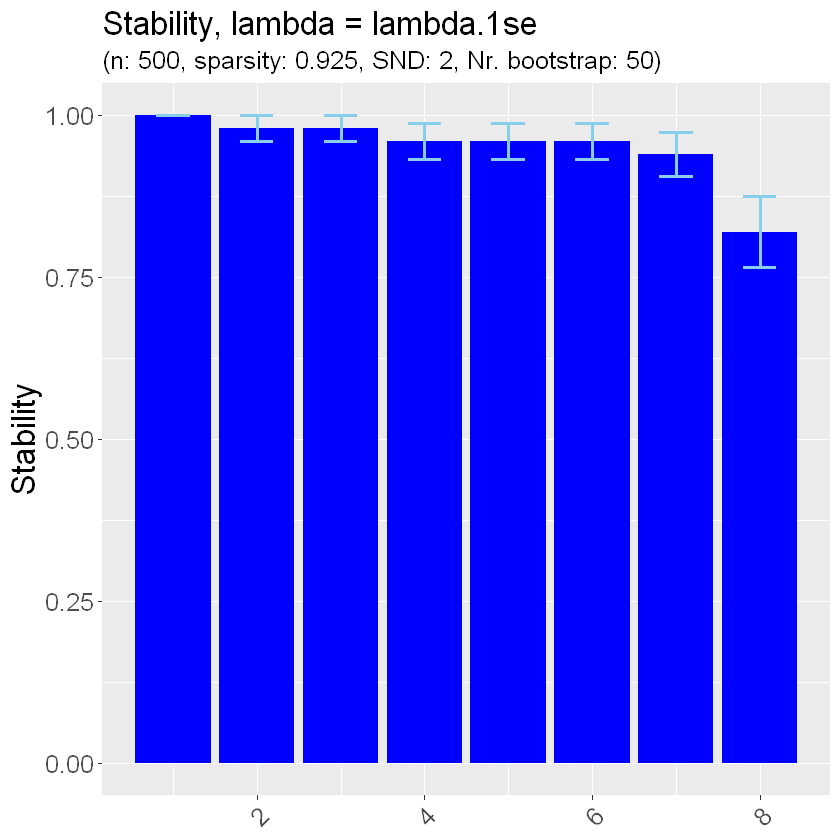

,freq,sd
,<dbl>,<dbl>
V93,50,0.0000000
V149,50,0.0000000
V529,50,0.0000000
V476,49,0.1414214
V947,49,0.1414214
V98,48,0.1979487
V982,47,0.2398979
V945,46,0.2740475
V779,45,0.3030458


,freq,sd
,<dbl>,<dbl>
V149,50,0.0000000
V93,49,0.1414214
V529,49,0.1414214
V98,48,0.1979487
V476,48,0.1979487
V947,48,0.1979487
V982,47,0.2398979
V251,41,0.3880879


,freq,sd
,<dbl>,<dbl>
V93,50,0.0000000
V149,50,0.0000000
V529,50,0.0000000
V476,49,0.1414214
V947,49,0.1414214
V98,48,0.1979487
V982,47,0.2398979
V945,46,0.2740475
V779,45,0.3030458


,freq,sd
,<dbl>,<dbl>
V78,50,0
V93,50,0
V97,50,0
V98,50,0
V102,50,0
V139,50,0
V149,50,0
V170,50,0
V177,50,0


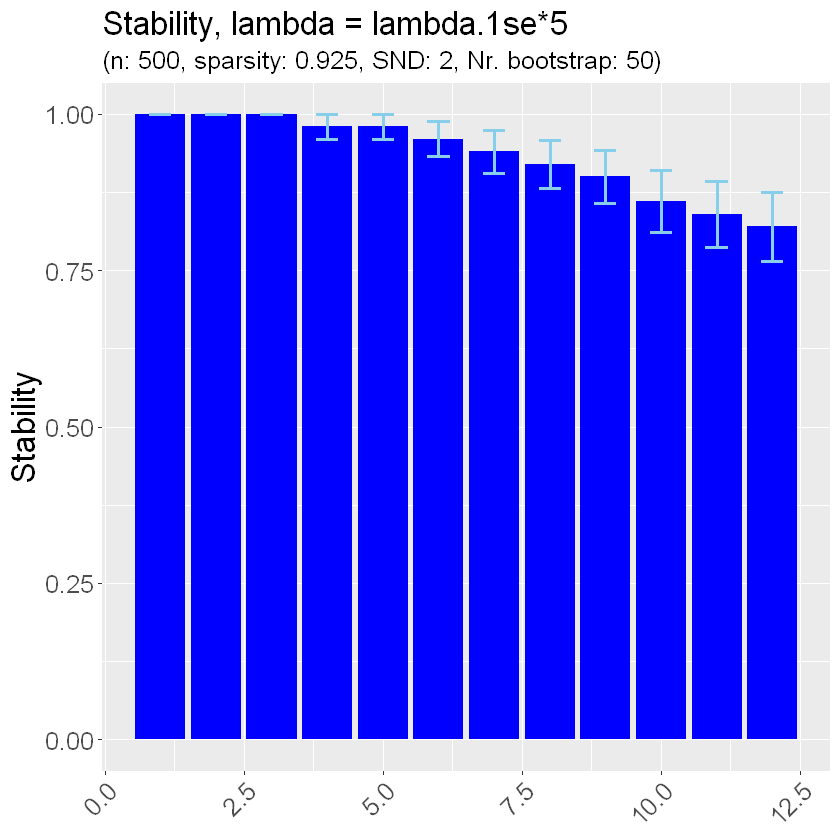

In [4]:

## ---- lambda.1se -------------------------------------------------------------

nz.min.tot.thresh <- subset(nz.min.tot, nz.min.tot$freq > ceiling(M*0.8))
nz.se.tot.thresh <- subset(nz.se.tot, nz.se.tot$freq > ceiling(M*0.8))
nz.max.tot.thresh <- subset(nz.max.tot, nz.max.tot$freq > ceiling(M*0.8))
#nz.true.tot.thresh <- nz.true.tot[nz.se.tot$freq > ceiling(M*0.8)]
## ---- plotting ---------------------------------------------------------------

ggplot((nz.min.tot.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.min.tot.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.min.tot.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
  labs(title = "Stability, lambda = lambda.1se/5",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", SND: ",SND,", Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 
#scale_y_continuous(breaks = seq(0, 1.2, by = 0.2))


ggplot((nz.se.tot.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.se.tot.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.se.tot.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
labs(title = "Stability, lambda = lambda.1se",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", SND: ",SND,", Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 


ggplot((nz.max.tot.thresh)) +
  geom_bar(aes(x = c(1:dim(nz.max.tot.thresh)[1]), 
               y = freq/M),
           stat = "identity", 
           fill = "blue") +
  #alpha = 0.7) +
  geom_errorbar(aes(x = c(1:dim(nz.max.tot.thresh)[1]), 
                    ymin = freq/M - sd/sqrt(M), 
                    ymax = freq/M + sd/sqrt(M)), 
                width = 0.4, 
                colour = "skyblue", 
                #alpha = 0.9, 
                size = 1) +
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1))+
labs(title = "Stability, lambda = lambda.1se*5",
       subtitle = paste0("(n: ",n,", sparsity: ",sparsity,", SND: ",SND,", Nr. bootstrap: ",
                         M, ")"),
       x = NULL, 
       y = "Stability") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        plot.subtitle = element_text(size = 15),
        plot.title = element_text(size = 20)) 




#A <- cbind(nz.true.tot.thresh, nz.se.tot.thresh)

list(nz.min.tot.thresh)
list(nz.se.tot.thresh)
list(nz.max.tot.thresh)
list(nz.true.tot)


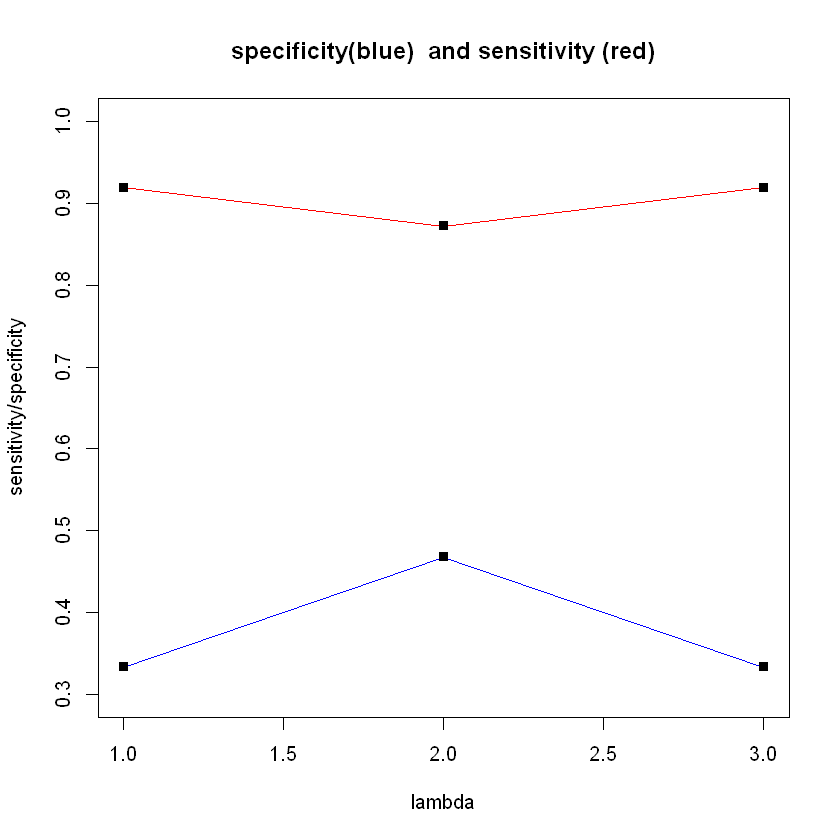

In [5]:
## ---- Comparing true and sparsity --------------------------------------------



specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- u > 0
  
  # Remove all zero entries in v
  u <- u[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  v <- v[non.zero.entries.est]
  
  # non-zero entries in u
  zero.in.true <- v == 0
  
  # Remove all zero entries in what is left of u
  v <- v[zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/(length(u)+length(v))
  
  return <- sens
  
}


spec.min <- matrix(0, dim(se.beta)[1],1)
sens.min <- matrix(0, dim(se.beta)[1],1)

spec.1se <- matrix(0, dim(se.beta)[1],1)
sens.1se <- matrix(0, dim(se.beta)[1],1)

spec.max <- matrix(0, dim(se.beta)[1],1)
sens.max <- matrix(0, dim(se.beta)[1],1)
for (i in (1:dim(se.beta)[1])){
  
  spec.min[i] <- specificity(min.beta[i, ], true.beta[i, ])
  sens.min[i] <- sensitivity(min.beta[i, ], true.beta[i, ])
  
  spec.1se[i] <- specificity(se.beta[i, ], true.beta[i, ])
  sens.1se[i] <- sensitivity(se.beta[i, ], true.beta[i, ])
  
  spec.max[i] <- specificity(max.beta[i, ], true.beta[i, ])
  sens.max[i] <- sensitivity(max.beta[i, ], true.beta[i, ])
}

spec <- rbind(spec.min,spec.1se,spec.max)

sens <- rbind(sens.min,sens.1se,sens.max)


dd <- as.data.frame(cbind(spec,sens, c("min","1se","max")))

colnames(dd) <- c("spec","sens", "variable")

variable <- factor(dd$variable, levels = c("min", "1se", "max"))





# create base scatter plot
plot(variable, dd$spec,
     ylim = c(0.3,1), col='blue', pch=18, type = "l",
     main = "specificity(blue)  and sensitivity (red)",
     xlab = "lambda", ylab = "sensitivity/specificity")

# overlay scatter plot 
points(variable, dd$sens, col='red', pch=15, type = "l")
points(variable, dd$sens, col='black', pch=15)
points(variable, dd$spec, col='black', pch=15)


In [6]:
A <- as.data.frame(cbind(row.names(nz.true.tot[c(1:5),]),row.names(nz.min.tot[c(1:5),]),row.names(nz.se.tot[c(1:5),]),
                        row.names(nz.max.tot[c(1:5),])))

colnames(A) <- c("true", "lasso, 1se/5", "lasso, 1se", "lasso, 1se*5")
 

A

true,"lasso, 1se/5","lasso, 1se","lasso, 1se*5"
<chr>,<chr>,<chr>,<chr>
V78,V93,V149,V93
V93,V149,V93,V149
V97,V529,V529,V529
V98,V476,V98,V476
V102,V947,V476,V947
